<font size = 20> Feature Engineering and Modelling</font>

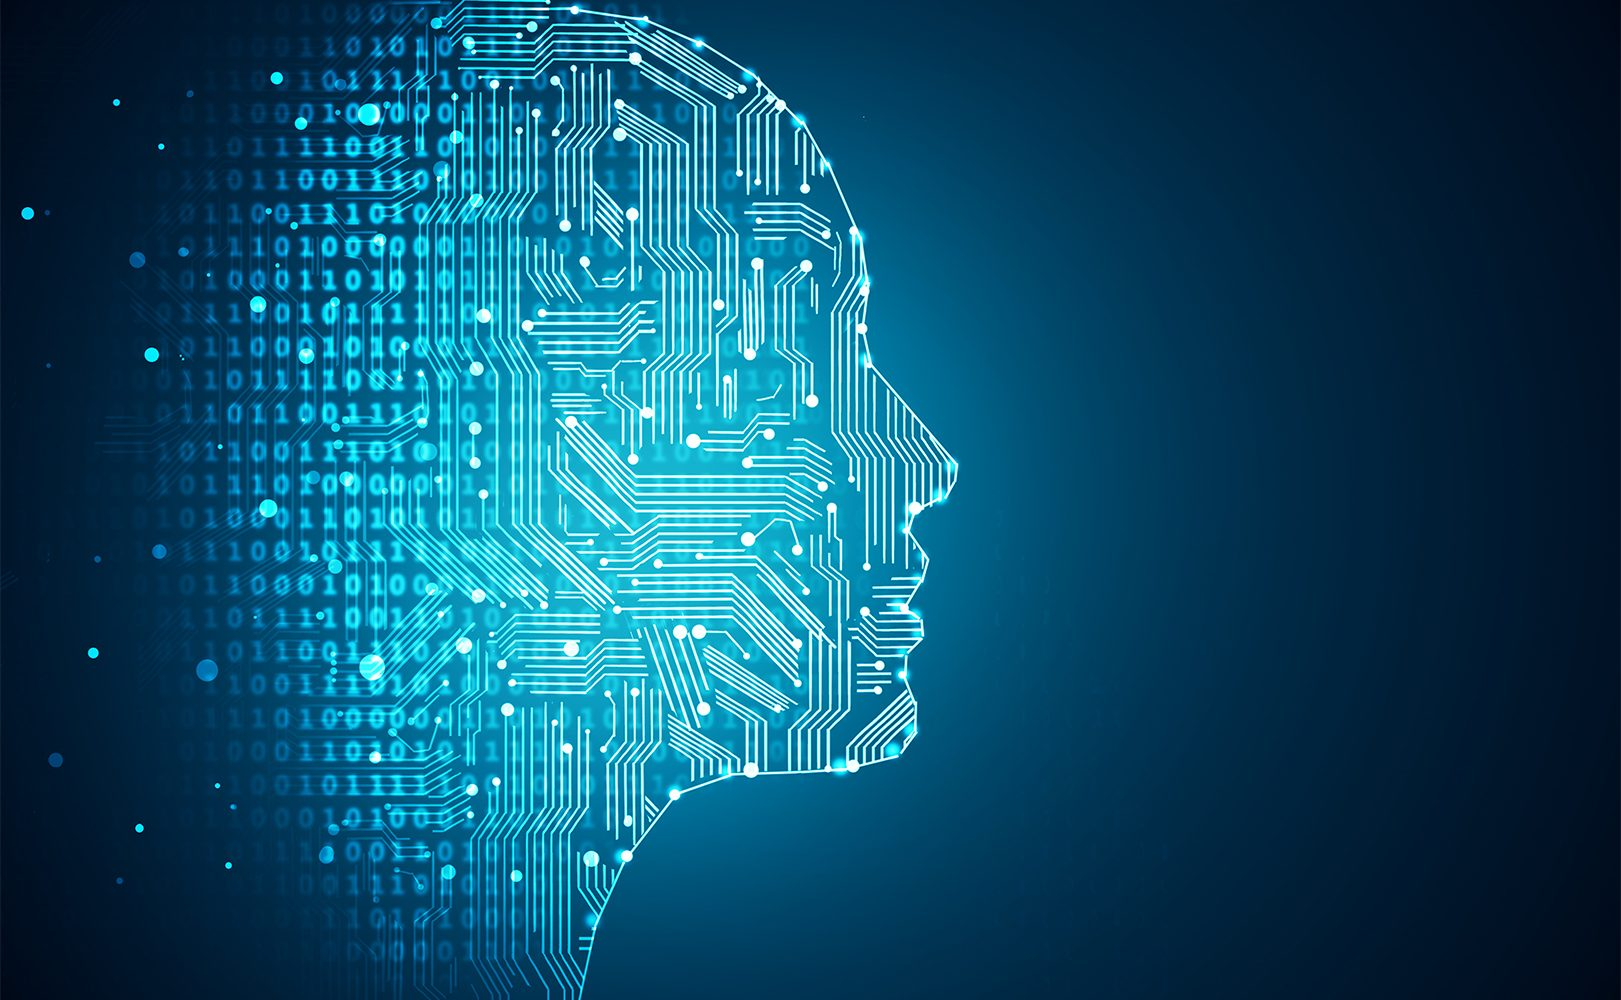

<pre><b>Feature Engineering and Feature Selection </b>

In this section, we will start off with the knowledge and isights gained from the Exploratory Data Analysis to Come up with Good Sets of Features using Feature Engineering. One thing to note here is that most of the features generated are based on domain knowledge and experimentations. Without good sets of features, Machine Learning Algorithms cannot produce effective results. Hence we will have to come up with ingenious ways to do feature engineering for the model to make better decisions. 
Apart from generating important/useful features, it is also critical to remove redundant and noisy features. If we feed garbage/noise to our Machine Learning Model, it will consequenty return garbage/noise. Thus we need to come up with good techniques of doing feature selection.

<b>Modelling</b>

After we are done with Feature Engineering, we will move to Machine Learning Modelling. We will start off with simple yet powerful Algorithms like Logistic Regression, Linear SVM, etc. and will then move to ensembles like Random Forests, Boosting Techniques, and finally stacking techniques. We will choose the models which give the best result.

# Preliminaries

## Loading Libraries

## Utility Functions and Classes

In [2]:
def reduce_mem_usage(data, verbose = True):
    #source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)
    
    return data

In [3]:
def relational_tables_prepare(file_directory = '', verbose = True):
    '''
    Function to pickle the relational tables which would need to be merged during production with the 
    test datapoint
    
    Inputs:
        file_directory: str, default = ''
            The directory in which files are saved
        verbose: bool, default = True
            Whether to keep verbosity or not
    
    Returns:
        None
    '''
    
    if verbose:
        print("Loading the tables into memory...")
        start = datetime.now()
        
    #loading all the tables in memory, for dimensionality reduction
    with open(file_directory + 'bureau_merged_preprocessed.pkl', 'rb') as f:
        bureau_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'previous_application_preprocessed.pkl', 'rb') as f:
        previous_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'installments_payments_preprocessed.pkl', 'rb') as f:
        installments_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'POS_CASH_balance_preprocessed.pkl', 'rb') as f:
        pos_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'credit_card_balance_preprocessed.pkl', 'rb') as f:
        cc_aggregated = reduce_mem_usage(pickle.load(f), verbose = False)
    with open(file_directory + 'application_train_preprocessed.pkl', 'rb') as f:
        application_train = reduce_mem_usage(pickle.load(f), verbose = False) 
    with open(file_directory + 'application_test_preprocessed.pkl', 'rb') as f:
        application_test = reduce_mem_usage(pickle.load(f), verbose = False)
    with open('Final_XGBOOST_Selected_features.pkl', 'rb') as f:
        final_cols = pickle.load(f)
        
    if verbose:
        print("Done.")
        print(f"Time Elapsed = {datetime.now() - start}")
        start2 = datetime.now()
        print("\nRemoving the non-useful features...")
    #removing non-useful columns from pre-processed previous_application table
    previous_app_columns_to_keep = set(previous_aggregated.columns).intersection(set(final_cols)).union(
                                    set([ele for ele in previous_aggregated.columns if 'AMT_ANNUITY' in ele] + [ele for ele in previous_aggregated.columns if 'AMT_GOODS' in ele]))
    previous_aggregated = previous_aggregated[previous_app_columns_to_keep]
    #removing non-useful columns from pre-processed credit_card_balance table
    credit_card_balance_columns_to_keep = set(cc_aggregated.columns).intersection(set(final_cols)).union(
                                    set([ele for ele in cc_aggregated.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele] + 
                                        [ele for ele in cc_aggregated.columns if 'AMT_RECIVABLE' in ele] + 
                                        [ele for ele in cc_aggregated.columns if 'TOTAL_RECEIVABLE' in ele] + ['SK_ID_CURR']))
    cc_aggregated = cc_aggregated[credit_card_balance_columns_to_keep]
    #removing non-useful columns from pre-processed installments_payments table
    installments_payments_columns_to_keep = set(installments_aggregated.columns).intersection(set(final_cols)).union(
                                            set([ele for ele in installments_aggregated.columns if 'AMT_PAYMENT' in 
                                                 ele and 'RATIO' not in ele and 'DIFF' not in ele] + ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']))
    installments_aggregated = installments_aggregated[installments_payments_columns_to_keep]
    #removing non-useful columns from pre-processed bureau-aggregated table
    bureau_columns_to_keep =  set(bureau_aggregated.columns).intersection(set(final_cols)).union([ele for ele in bureau_aggregated.columns
                                        if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele] + [ele for ele in bureau_aggregated.columns if
                                        'AMT_CREDIT' in ele and 'OVERDUE' in ele] + [ele for ele in bureau_aggregated.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele])
    bureau_aggregated = bureau_aggregated[bureau_columns_to_keep]
    
    if verbose:
        print("Done.")
        print(f"Time Elapsed = {datetime.now() - start2}")
        print("\nMerging all the tables, and saving to pickle file 'relational_table.pkl'...")

    #merging all the tables
    relational_table = cc_aggregated.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = relational_table.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'outer')
    relational_table = reduce_mem_usage(relational_table, verbose = False)

    with open(file_directory + 'relational_table.pkl', 'wb') as f:
        pickle.dump(relational_table, f)
    
    if verbose:
        print("Done.")
        print(f"Total Time taken = {datetime.now() - start}")

In [4]:
class modelling:
    '''
    Class for Doing Hyperparameter tuning to find best set of hyperparameters, building models on best hyperparams and
    displaying results on best hyperparameters.
    
    It has 4 methods:
        1. init method
        2. random_search_cv method
        3. train_on_best_params method
        4. proba_to_class method
        5. tune_threshold method
        6. results_on_best_params method
        7. feat_importances_show method
    '''
    def __init__(self, base_model, x_train, y_train, x_test, calibration = False, calibration_method = 'isotonic',
                 calibration_cv = 4, k_folds = 4, random_state = 982):
        '''
        Function to initialize the class members.
        
        Inputs: 
            self
            base_model: estimator/classifier
                The base model to be used for the modelling purpose
            x_train: numpy array
                Training standardized data
            y_train: numpy array
                Training class labels
            x_test: numpy array
                Test standardized data
            calibration: bool, default = False
                Whether to calibrate the model for generating class probabilities
            calibration_method: str, default = 'isotonic'
                The type of calibration to use, i.e. sigmoid or isotonic
            calibration_cv: int, default = 4
                Number of cross-validation folds for calibrating the probabilities
            k_folds: int, default = 4
                Number of cross-validation folds for training and tuning the model
            random_state: int, default = 982
                Random state for StratifiedKFold for reproducibility
                
        Returns: 
            None            
        '''
        self.base_model = base_model
        self.num_folds = k_folds
        self.kfolds = StratifiedKFold(n_splits = k_folds, shuffle = True, random_state = random_state)
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.calibration = calibration
        if self.calibration:
            self.calibration_method = calibration_method
            self.calibration_cv = calibration_cv

    def random_search_cv(self, hyperparams_dict, n_iter = 30, verbose = True, n_jobs = 1, random_state = 843):
        '''
        Function to do RandomizedSearchCV on training data.
        
        Inputs:
            self
            hyperparams_dict: dict
                Dictionary of hyperparameters to tune
            n_iter: int, default = 30
                Number of iterations to perform for random search
            verbose: bool, default = True
                Whether to keep verbosity or not
            n_jobs: int, default = 1
                Number of cores to use for Random Search
            random_state: int, default = 843
                Random state for reproducibility of RandomizedSearchCV
                
        Returns:
            None
        '''
        
        if verbose:
            start = datetime.now()
            print(f"Doing Randomized Search CV on Classifier with {n_iter} random initializations...")
        rscv = RandomizedSearchCV(self.base_model, hyperparams_dict, n_iter = n_iter, scoring = 'roc_auc', 
                                  cv = self.kfolds, return_train_score = True, verbose = 2,
                                  n_jobs = n_jobs, random_state = random_state)
        rscv.fit(self.x_train, self.y_train)
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        
        #getting the Search Results
        self.tuning_results = pd.DataFrame(rscv.cv_results_)
        #best model
        self.best_model = rscv.best_estimator_
        
        gc.collect()
        
    def train_on_best_params(self, verbose = True):
        '''
        Function to train the model on best hyperparameters obtained from previous method.
        Generates Cross-Validation predictions as Out-of-fold predictions
        
        Inputs:
            self
            verbose: bool, default = True
                Whether to keep verbosity or not
        
        Returns:
            None
        '''
        
        if verbose:
            print("Fitting Classifier on best parameters\n")
            print(f"{self.num_folds}-Fold Cross Validation")
            start = datetime.now()
            
        self.cv_preds_probas = np.zeros(self.x_train.shape[0])
        #we will select a best threshold for each fold of cross-validation and average over the
        #folds to find the optimal threshold
        self.best_threshold_train = 0
        for fold_number, (train_indices, val_indices) in enumerate(self.kfolds.split(self.x_train, self.y_train), 1):
            if verbose:
                print(f"\tFitting Fold {fold_number}")
                
            self.best_model.fit(self.x_train[train_indices], self.y_train[train_indices])
            if not self.calibration:
                self.train_preds_probas = self.best_model.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.best_model.predict_proba(self.x_train[val_indices])[:,1]
            else:
                #fitting the calibration Classifier over the base model for calibrated probabilities
                self.calibrated_classifier = CalibratedClassifierCV(self.best_model, method = self.calibration_method, cv = self.calibration_cv)
                self.calibrated_classifier.fit(self.x_train[train_indices], self.y_train[train_indices])
                
                self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train[train_indices])[:,1]
                self.cv_preds_probas[val_indices] = self.calibrated_classifier.predict_proba(self.x_train[val_indices])[:,1]
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_probas) / self.num_folds
        
        #converting the class probabilities to class labels
        self.cv_preds_class = self.proba_to_class(self.cv_preds_probas, self.best_threshold_train)
        
        if verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
            
        gc.collect()
    
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''
        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''
        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
        
    def results_on_best_params(self, model_name):
        '''
        Function to train the whole data on best parameters and display the results.
        
        Inputs:
            self
            model_name: str
                model name to get feature importances.
        
        Returns:
            None
        '''
        #we have to fit the whole model for optimal test predictions
        self.best_model.fit(self.x_train, self.y_train)
        if not self.calibration:
            self.train_preds_probas = self.best_model.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.best_model.predict_proba(self.x_test)[:,1]
        else:
            #fitting calibration model over whole training data for test predictions
            self.calibrated_classifier.fit(self.x_train, self.y_train)
            self.train_preds_probas = self.calibrated_classifier.predict_proba(self.x_train)[:,1]
            self.test_preds_probas = self.calibrated_classifier.predict_proba(self.x_test)[:,1]
        
        #getting class labels from probabilities
        self.train_preds_class = self.proba_to_class(self.train_preds_probas, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_probas, self.best_threshold_train)
        
        #feature importances
        if model_name == 'linear':
            self.feat_imp = self.best_model.coef_[0]
        else:
            self.feat_imp = self.best_model.feature_importances_
                
        print("=" * 100)
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        print("Train Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_probas)}")
        print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
        print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        print('=' * 100)
        print("Confusion Matrix of CV data:")
        conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
        conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
        plt.figure(figsize = (7,6))
        plt.title('Confusion Matrix Heatmap')
        sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
        plt.show()
        
        print('=' * 100)
        print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
        plt.figure(figsize = (20,6))
        plt.subplot(1,3,1)
        plt.title('Class Distribution of Original Dataset')
        sns.countplot(self.y_train)
        plt.subplot(1,3,2)
        plt.title('Class Distribution of predicted Class Labels on CV')
        sns.countplot(self.cv_preds_class)
        plt.subplot(1,3,3)
        plt.title('Class Distribution of predicted Test Dataset')
        sns.countplot(self.test_preds_class)
        plt.show()
        print('=' * 100)
        
        gc.collect()
        
    def feat_importances_show(self, feature_names, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            feature_names: numpy array
                Names of features of training set
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        #getting the top features indices and their names
        top_feats_indices = np.argsort(self.feat_imp)[::-1][:num_features]
        feat_importance_top = self.feat_imp[top_feats_indices]
        column_names = feature_names[top_feats_indices]
        
        #plotting a horizontal bar plot of feature importances
        plt.figure(figsize = figsize) 
        sns.barplot(feat_importance_top, list(range(num_features)), orient = 'h')
        plt.yticks(list(range(50)), column_names)
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

In [5]:
class Boosting:
    '''
    Class for Boosting Ensembles and displaying results. Contains 6 methods:
    
        1. init method
        2. train method
        3. proba_to_class method
        4. tune_threshold method
        5. results method
        6. feat_importance_show
    '''

    def __init__(self, x_train, y_train, x_test, params, num_folds = 3, random_state = 33, verbose = True, save_model_to_pickle = False):
        '''
        Function to initialize the class members.
        
        Inputs:
            self
            x_train: DataFrame
                Training DataFrame
            y_train: DataFrame
                Training Class labels
            x_test: DataFrame
                Test DataFrame
            params: dict
                Parameters for the boosting ensemble
            num_folds: int, default = 3
                Number of folds for k-Fold Cross Validation
            random_state: int, default = 33
                Random State for Splitting the data for K-Fold Cross Validation
            verbose: bool, default = True
                Whether to keep verbosity or not
            save_model_to_pickle: bool, default = False
                Whether to save the model to pickle file or not
        
        Returns:
            None
        '''

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.params = params
        self.num_folds = num_folds
        self.stratified_cv = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = random_state)
        self.verbose = verbose
        self.save_model = save_model_to_pickle
        
    def train(self, booster, verbose = 400, early_stopping = 200, pickle_name = ''):
        '''
        Function to train the Classifier on given parameters. It fits the classifier for each fold, and for Cross Validation,
        uses Out-of-Fold Predictions. The test predictions are averaged predictions over each fold.
        
        Inputs:
            self
            booster: str
                Whether the booster is 'xgboost' or 'lightgbm'
            verbose: int, default = 400
                Number of boosting rounds for printint boosting results.
            early_stopping: int, default = 200
                Number of boosting rounds to look for early stopping
            pickle_name: str, default = ''
                The string to add to end of pickle file of model, if any
        
        Returns:
            None        
        '''
        
        self.train_preds_proba_mean = np.zeros(self.x_train.shape[0])
        #out-of-fold cv predictions
        self.cv_preds_proba = np.zeros(self.x_train.shape[0])
        self.test_preds_proba_mean = np.zeros(self.x_test.shape[0])
        #best threshold will be 
        self.best_threshold_train = 0
        self.feature_importance = pd.DataFrame()
        self.feature_importance['features'] = self.x_train.columns
        self.feature_importance['gain'] = np.zeros(self.x_train.shape[1])
        
        if self.verbose:
            print(f"Fitting the {booster} on Training Data with {self.num_folds} fold cross validation, and using Out-Of-Folds Predictions for Cross-Validation")
            start = datetime.now()
        
        for fold_number, (train_indices, cv_indices) in enumerate(self.stratified_cv.split(self.x_train, self.y_train), 1):
            if self.verbose:
                print(f"\n\tFold Number {fold_number}\n")
            
            x_tr = self.x_train.iloc[train_indices]
            y_tr = self.y_train.iloc[train_indices]
            x_cv = self.x_train.iloc[cv_indices]
            y_cv = self.y_train.iloc[cv_indices]
            
            if booster == 'xgboost':
                clf = XGBClassifier(**self.params)
            else:
                clf = LGBMClassifier(**self.params)
                
            clf.fit(x_tr, y_tr, eval_set = [(x_tr, y_tr), (x_cv, y_cv)], eval_metric = 'auc',
                     verbose = verbose, early_stopping_rounds = 200)
            
            if booster == 'xgboost':
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, ntree_limit = clf.get_booster().best_ntree_limit)[:, 1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, ntree_limit = clf.get_booster().best_ntree_limit)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, ntree_limit = clf.get_booster().best_ntree_limit)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.get_booster().get_score(importance_type = 'gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = gain_fold.keys()
                feat_imp['gain'] = gain_fold.values()
            
            else:
                self.train_preds_proba_mean[train_indices] = clf.predict_proba(x_tr, num_iteration = clf.best_iteration_)[:,1] / (self.num_folds - 1)
                self.cv_preds_proba[cv_indices] = clf.predict_proba(x_cv, num_iteration = clf.best_iteration_)[:,1]
                self.test_preds_proba_mean += clf.predict_proba(self.x_test, num_iteration = clf.best_iteration_)[:,1] / self.num_folds

                #feature importance
                gain_fold = clf.booster_.feature_importance(importance_type='gain')
                feat_imp = pd.DataFrame()
                feat_imp['features'] = self.x_train.columns
                feat_imp['gain'] = gain_fold
            
            #tuning the threshold for optimal TPR and FPR from ROC Curve
            self.best_threshold_train += self.tune_threshold(self.y_train[train_indices], self.train_preds_proba_mean[train_indices]) / self.num_folds
            #concatenating the feature importance of each fold to original df
            self.feature_importance = pd.concat([self.feature_importance, feat_imp], axis = 0)

            if self.save_model:
                #saving the model into a pickle file
                with open(f'clf_{booster}_fold_{fold_number}_model_{pickle_name}.pkl', 'wb') as f:
                    pickle.dump(clf, f)
          
        #mean feature importance averaged over all folds
        self.feature_importance = self.feature_importance.groupby('features', as_index = False).mean()
        #sorting the feature importance
        self.feature_importance = self.feature_importance.sort_values(by = 'gain', ascending = False)
        
        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
        gc.collect()
        
    def proba_to_class(self, proba, threshold):
        '''
        Function to convert a given probability to class label based on a threshold value.
        
        Inputs:
            self
            proba: numpy array
                Probabilities of class label = 1
            threshold: int
                Threshold probability to be considered as Positive or Negative Class Label
            
        Returns:
            Converted Class Label
        '''

        return np.where(proba >= threshold, 1, 0)
        
    def tune_threshold(self, true_labels, predicted_probas):
        '''
        Function to find the optimal threshold for maximizing the TPR and minimizing the FPR from ROC-AUC Curve.
        This is found out by using the J Statistic, which is J = TPR - FPR.
        Reference: https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/
        
        Inputs:
            self
            true_labels: numpy array or pandas series
                True Class Labels
            predicted_probas: numpy array
                Predicted Probability of Positive Class label
            
        Returns:
            Threshold probability.
        '''

        fpr, tpr, threshold = roc_curve(true_labels, predicted_probas)
        j_stat = tpr - fpr
        index_for_best_threshold = np.argmax(j_stat)
        
        return threshold[index_for_best_threshold]
           
    def results(self, roc_auc = True, precision_recall = True, confusion_matrix = True, cv_test_distribution = False):
        '''
        Function to display the final results of Train, CV and Test Dataset.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        #getting the crisp class labels
        self.train_preds_class = self.proba_to_class(self.train_preds_proba_mean, self.best_threshold_train)
        self.cv_preds_class = self.proba_to_class(self.cv_preds_proba, self.best_threshold_train)
        self.test_preds_class = self.proba_to_class(self.test_preds_proba_mean, self.best_threshold_train)
        print("=" * 100)
        print("Train Results:")
        print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {self.best_threshold_train}\n")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.train_preds_proba_mean)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.train_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.train_preds_class)}")
        print("CV Results:")
        if roc_auc:
            print(f"\tROC-AUC Score = {roc_auc_score(self.y_train, self.cv_preds_proba)}")
        if precision_recall:
            print(f"\tPrecision Score = {precision_score(self.y_train, self.cv_preds_class)}")
            print(f"\tRecall Score = {recall_score(self.y_train, self.cv_preds_class)}")

        if confusion_matrix:
            print('=' * 100)
            print("Confusion, Precision and Recall Matrix on CV data:")
            conf_mat = confusion_matrix(self.y_train, self.cv_preds_class)
            conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
            plt.figure(figsize = (7,6))
            plt.title('Confusion Matrix Heatmap')
            sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
            plt.show()
        
        if cv_test_distribution:
            print('=' * 100)
            print("Distribution of Original Class Labels and Predicted CV and Test Class Labels")
            plt.figure(figsize = (20,6))
            plt.subplot(1,3,1)
            plt.title('Class Distribution of Original Dataset')
            sns.countplot(self.y_train)
            plt.subplot(1,3,2)
            plt.title('Class Distribution of predicted Class Labels on CV')
            sns.countplot(self.cv_preds_class)
            plt.subplot(1,3,3)
            plt.title('Class Distribution of predicted Test Dataset')
            sns.countplot(self.test_preds_class)
            plt.show()
        print('=' * 100)
        
        gc.collect()
    
    def feat_importances_show(self, num_features, figsize = (10,15)):
        '''
        Function to display the top most important features.
        
        Inputs:
            self
            num_features: int
                Number of top features importances to display
            figsize: tuple, default = (10,15)
                Size of figure to be displayed
            
        Returns:
            None
        '''
        
        plt.figure(figsize = figsize) 
        sns.barplot(self.feature_importance['gain'].iloc[:num_features], self.feature_importance['features'].iloc[:num_features], orient = 'h')
        plt.title(f'Top {num_features} features as per classifier')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature Names')
        plt.grid()
        plt.show()
        print('=' * 100)
        
        gc.collect()

# Data Cleaning and Feature Engineering

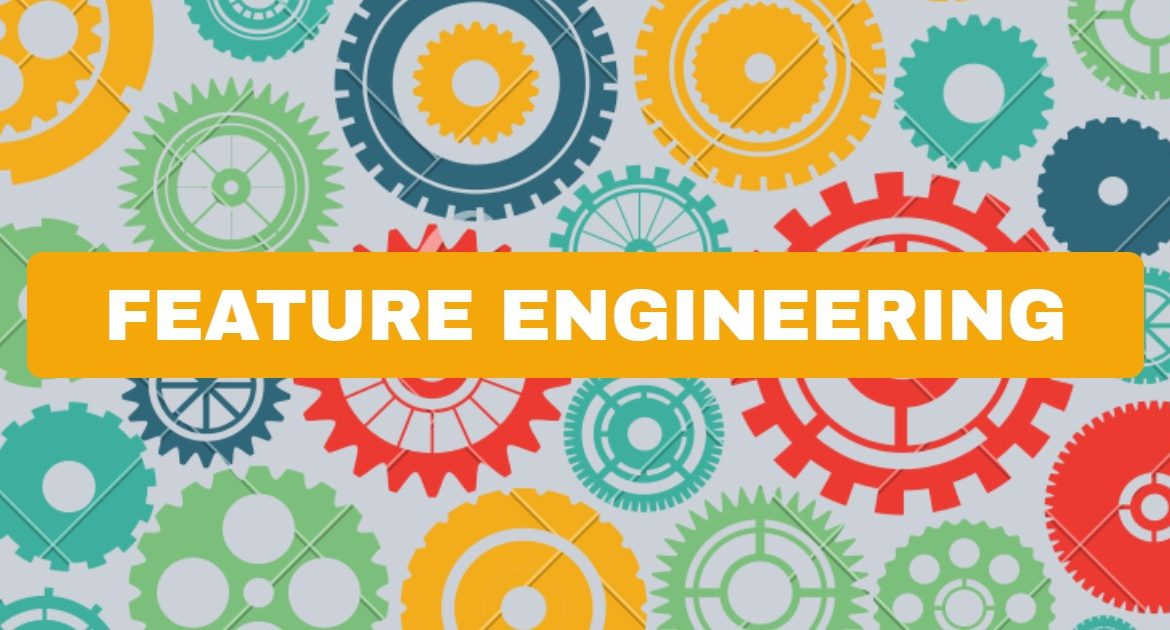

The data contains several number of relational tables. We'll process each one of them separately, and then finally in the end, merge all of them together.

## Preprocessing Tables

### bureau_balance.csv and bureau.csv

These tables contain the information related to the client's previous credits which were not with Home Credit Group, and were reported by Credit Bureau Department. 
<ol><li><b>bureau_balance</b>
    <ol><li>First off, the bureau_balance table contains three fields, i.e. SK_ID_BUREAU, MONTHS_BALANCE and STATUS.</li>
        <li>Since the Status follows somewhat ordinal behaviour, we start by label encoding it.</li>
        <li>Next, some features are created such as weighted status, which is obtained by dividing the status by the MONTHS_BALANCE.</li>
        <li>Since the data contains the timeseries, we also calculate the Exponential Weighted Moving Average of the Status and Weighted Status fields.</li>
        <li>Finally, we aggregate the data over SK_ID_BUREAU, in such a way that we first aggregate it over all the data, and after that we also aggregate over the last 2 years. These 2 years would depict the more recent behaviour of the clients.</li>
        <li>The aggregations performed are based on Domain Knowledge, such as mean, min, max, sum, count, etc. For EDA features, we only take the last/most recent values, as they somewhat contain the trend of all the previous values.</li></ol>
    <li><b>bureau</b>
    <ol><li>Firstly, we merge the bureau table with the aggregated bureau_balance table from previous step, on SK_ID_BUREAU.</li>
        <li>We replace some erroneous values with NaN values. We saw some loans dating back to as long as 100 years ago. We believe they wouldn't really tell much about client's recent behaviour, so we remove them and only keep the loans in the period of 50 years.</li>
        <li>We create some features by multiplications, divisions, subtractions of raw features, based on domain knowledge, such as Credit duration, annutiy to credit ratio, etc.</li>
        <li>The categorical features are one-hot encoded.
        <li>To merge these to main table, i.e. application_train, we aggregate this table over SK_ID_CURR. We perform the aggregations again in two ways. We aggregate the credits based on the CREDIT_ACTIVE category, where we aggregate for two most popular categories separately, i.e. Active, and Closed. Later we aggregate for the remaining categories too, and merge these. We aggregated the whole data overall too. The aggregations performed are sum, mean, min, max, last, etc.</li>
        </ol></li></ol>
            

In [6]:
class preprocess_bureau_balance_and_bureau:
    '''
    Preprocess the tables bureau_balance and bureau.
    Contains 4 member functions:
        1. init method
        2. preprocess_bureau_balance method
        3. preprocess_bureau method
        4. main method
    '''
    
    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        self.start = datetime.now()
        
    def preprocess_bureau_balance(self):
        '''
        Function to preprocess bureau_balance table.
        This function first loads the table into memory, does some feature engineering, and finally
        aggregates the data over SK_ID_BUREAU
        
        Inputs:
            self
            
        Returns:
            preprocessed and aggregated bureau_balance table.
        '''
        
        if self.verbose:
            print('#######################################################')
            print('#          Pre-processing bureau_balance.csv          #')
            print('#######################################################')
            print("\nLoading the DataFrame, bureau_balance.csv, into memory...")

        bureau_balance = pd.read_csv(self.file_directory + 'bureau_balance.csv')

        if self.verbose:
            print("Loaded bureau_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
            print("\nStarting Data Cleaning and Feature Engineering...")

        #as we saw from EDA, bureau_balance has a variable called STATUS, which describes about the status of loan.
        #it has 7 labels, we will label encode them
        #so we give C as 0, and rest increasing
        #also we will give X the benefit of doubt and keep it as middle value
        dict_for_status = { 'C': 0, '0': 1, '1': 2, '2': 3, 'X': 4, '3': 5, '4': 6, '5': 7}
        bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_for_status)

        #weighing the status with the months_balance
        #converting months to positive
        bureau_balance['MONTHS_BALANCE'] = np.abs(bureau_balance['MONTHS_BALANCE'])
        bureau_balance['WEIGHTED_STATUS'] = bureau_balance.STATUS / (bureau_balance.MONTHS_BALANCE + 1)

        #sorting the bureau_balance in ascending order of month and by the bureau SK_ID
        #this is done so as to make the rolling exponential average easily for previous months till current month
        bureau_balance = bureau_balance.sort_values(by=['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[0, 0])
        #we will do exponential weighted average on the encoded status
        #this is because if a person had a bad status 2 years ago, it should be given less weightage today
        # we keep the latent variable alpha = 0.8 
        #doing this for both weighted status and the status itself
        bureau_balance['EXP_WEIGHTED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['WEIGHTED_STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())
        bureau_balance['EXP_ENCODED_STATUS'] = bureau_balance.groupby('SK_ID_BUREAU')['STATUS'].transform(lambda x: x.ewm(alpha = 0.8).mean())    

        if self.verbose:
            print("Halfway through. A little bit more patience...")
            print(f"Total Time Elapsed = {datetime.now() - self.start}")

        #we can see that these datapoints are for 96 months i.e. 8 years.
        #so we will extract the means, and exponential averages for each year separately
        #first we convert month to year
        bureau_balance['MONTHS_BALANCE'] = bureau_balance['MONTHS_BALANCE'] // 12

        #defining our aggregations
        aggregations_basic = {
            'MONTHS_BALANCE' : ['mean','max'],
            'STATUS' : ['mean','max','first'],
            'WEIGHTED_STATUS' : ['mean','sum','first'],
            'EXP_ENCODED_STATUS' : ['last'],
            'EXP_WEIGHTED_STATUS' : ['last']}

        #we will be finding aggregates for each year too
        aggregations_for_year = {
            'STATUS' : ['mean','max','last','first'],
            'WEIGHTED_STATUS' : ['mean','max', 'first','last'],
            'EXP_WEIGHTED_STATUS' : ['last'],
            'EXP_ENCODED_STATUS' : ['last'] }

        #aggregating over whole dataset first
        aggregated_bureau_balance = bureau_balance.groupby(['SK_ID_BUREAU']).agg(aggregations_basic)
        aggregated_bureau_balance.columns = ['_'.join(ele).upper() for ele in aggregated_bureau_balance.columns]

        #aggregating some of the features separately for latest 2 years
        aggregated_bureau_years = pd.DataFrame()
        for year in range(2):
            year_group = bureau_balance[bureau_balance['MONTHS_BALANCE'] == year].groupby('SK_ID_BUREAU').agg(aggregations_for_year)
            year_group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in year_group.columns]

            if year == 0:
                aggregated_bureau_years = year_group
            else:
                aggregated_bureau_years = aggregated_bureau_years.merge(year_group, on = 'SK_ID_BUREAU', how = 'outer')

        #aggregating for rest of the years
        aggregated_bureau_rest_years = bureau_balance[bureau_balance.MONTHS_BALANCE > year].groupby(['SK_ID_BUREAU']).agg(aggregations_for_year)
        aggregated_bureau_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in aggregated_bureau_rest_years.columns]

        #merging with rest of the years
        aggregated_bureau_years = aggregated_bureau_years.merge(aggregated_bureau_rest_years, on = 'SK_ID_BUREAU', how = 'outer')
        aggregated_bureau_balance = aggregated_bureau_balance.merge(aggregated_bureau_years, on = 'SK_ID_BUREAU', how = 'inner')

        #filling the missing values obtained after aggregations with 0
        aggregated_bureau_balance.fillna(0, inplace = True)

        if self.verbose:
            print('Done preprocessing bureau_balance.')
            print(f"\nInitial Size of bureau_balance: {bureau_balance.shape}")
            print(f'Size of bureau_balance after Pre-Processing, Feature Engineering and Aggregation: {aggregated_bureau_balance.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed bureau_balance to bureau_balance_preprocessed.pkl')
            with open(self.file_directory + 'bureau_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(aggregated_bureau_balance, f)
            if self.verbose:
                print('Done.')     
        
        return aggregated_bureau_balance
    
    def preprocess_bureau(self, aggregated_bureau_balance):
        '''
        Function to preprocess the bureau table and merge it with the aggregated bureau_balance table.
        Finally aggregates the data over SK_ID_CURR for it to be merged with application_train table.
        
        Inputs:
            self
            aggregated_bureau_balance: DataFrame of aggregated bureau_balance table
        
        Returns:
            Final preprocessed, merged and aggregated bureau table
        '''
        
        if self.verbose:
            start2 = datetime.now()
            print('\n##############################################')
            print('#          Pre-processing bureau.csv         #')
            print('##############################################')
            print("\nLoading the DataFrame, bureau.csv, into memory...")

        bureau = pd.read_csv(self.file_directory + 'bureau.csv')

        if self.verbose:
            print("Loaded bureau.csv")
            print(f"Time Taken to load = {datetime.now() - start2}")
            print("\nStarting Data Cleaning and Feature Engineering...")

        #merging it with aggregated bureau_balance on 'SK_ID_BUREAU'
        bureau_merged = bureau.merge(aggregated_bureau_balance, on = 'SK_ID_BUREAU', how = 'left')

        #from the EDA we saw some erroneous values in DAYS Fields, we will remove those
        #there are some loans which ended about very long ago, around 100 years ago.
        #Thus we will only keep those loans which have ended in past 50 years.
        bureau_merged['DAYS_CREDIT_ENDDATE'][bureau_merged['DAYS_CREDIT_ENDDATE'] > -50*365] = np.nan
        bureau_merged['DAYS_ENDDATE_FACT'][bureau_merged['DAYS_ENDDATE_FACT'] > -50*365] = np.nan
        #there is also a feature which tells about the number of days ago the Credit Report Came
        bureau_merged['DAYS_CREDIT_UPDATE'][bureau_merged['DAYS_CREDIT_UPDATE'] > -50*365] = np.nan
        
        #engineering some features based on domain knowledge
        bureau_merged['CREDIT_DURATION'] = np.abs(bureau_merged['DAYS_CREDIT'] - bureau_merged['DAYS_CREDIT_ENDDATE'])
        bureau_merged['FLAG_OVERDUE_RECENT'] = [0 if ele == 0 else 1 for ele in bureau_merged['CREDIT_DAY_OVERDUE']]
        bureau_merged['MAX_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_MAX_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['CURRENT_AMT_OVERDUE_DURATION_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['AMT_OVERDUE_DURATION_LEFT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_OVERDUE'] / (bureau_merged['DAYS_CREDIT_ENDDATE'] + 0.00001)
        bureau_merged['CNT_PROLONGED_MAX_OVERDUE_MUL'] = bureau_merged['CNT_CREDIT_PROLONG'] * bureau_merged['AMT_CREDIT_MAX_OVERDUE']
        bureau_merged['CNT_PROLONGED_DURATION_RATIO'] = bureau_merged['CNT_CREDIT_PROLONG'] / (bureau_merged['CREDIT_DURATION'] + 0.00001)
        bureau_merged['CURRENT_DEBT_TO_CREDIT_RATIO'] = bureau_merged['AMT_CREDIT_SUM_DEBT'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
        bureau_merged['CURRENT_CREDIT_DEBT_DIFF'] = bureau_merged['AMT_CREDIT_SUM'] - bureau_merged['AMT_CREDIT_SUM_DEBT']
        bureau_merged['AMT_ANNUITY_CREDIT_RATIO'] = bureau_merged['AMT_ANNUITY'] / (bureau_merged['AMT_CREDIT_SUM'] + 0.00001)
        bureau_merged['CREDIT_ENDDATE_UPDATE_DIFF'] = np.abs(bureau_merged['DAYS_CREDIT_UPDATE'] - bureau_merged['DAYS_CREDIT_ENDDATE'])

        #now we will be aggregating the bureau_merged df with respect to 'SK_ID_CURR' so as to merge it with application_train later    
        #firstly we will aggregate the columns based on the category of CREDIT_ACTIVE
        aggregations_CREDIT_ACTIVE = {
                        'DAYS_CREDIT' : ['mean','min','max','last'],
                        'CREDIT_DAY_OVERDUE' : ['mean','max'],
                        'DAYS_CREDIT_ENDDATE' : ['mean','max'],
                        'DAYS_ENDDATE_FACT' : ['mean','min'],
                        'AMT_CREDIT_MAX_OVERDUE': ['max','sum'],
                        'CNT_CREDIT_PROLONG': ['max','sum'],
                        'AMT_CREDIT_SUM' : ['sum','max'],
                        'AMT_CREDIT_SUM_DEBT': ['sum'],
                        'AMT_CREDIT_SUM_LIMIT': ['max','sum'],
                        'AMT_CREDIT_SUM_OVERDUE': ['max','sum'],
                        'DAYS_CREDIT_UPDATE' : ['mean','min'],
                        'AMT_ANNUITY' : ['mean','sum','max'],
                        'CREDIT_DURATION' : ['max','mean'],
                        'FLAG_OVERDUE_RECENT': ['sum'],
                        'MAX_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                        'CURRENT_AMT_OVERDUE_DURATION_RATIO' : ['max','sum'],
                        'AMT_OVERDUE_DURATION_LEFT_RATIO' : ['max', 'mean'],
                        'CNT_PROLONGED_MAX_OVERDUE_MUL' : ['mean','max'],
                        'CNT_PROLONGED_DURATION_RATIO' : ['mean', 'max'],
                        'CURRENT_DEBT_TO_CREDIT_RATIO' : ['mean', 'min'],
                        'CURRENT_CREDIT_DEBT_DIFF' : ['mean','min'],
                        'AMT_ANNUITY_CREDIT_RATIO' : ['mean','max','min'],
                        'CREDIT_ENDDATE_UPDATE_DIFF' : ['max','min'],
                        'STATUS_MEAN' : ['mean', 'max'],
                        'WEIGHTED_STATUS_MEAN' : ['mean', 'max']
                         }

        #we saw from EDA that the two most common type of CREDIT ACTIVE were 'Closed' and 'Active'.
        #So we will aggregate them two separately and the remaining categories separately.
        categories_to_aggregate_on = ['Closed','Active']
        bureau_merged_aggregated_credit = pd.DataFrame()
        for i, status in enumerate(categories_to_aggregate_on):
            group = bureau_merged[bureau_merged['CREDIT_ACTIVE'] == status].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
            group.columns = ['_'.join(ele).upper() + '_CREDITACTIVE_' + status.upper() for ele in group.columns]

            if i==0:
                bureau_merged_aggregated_credit = group
            else:
                bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(group, on = 'SK_ID_CURR', how = 'outer')
        #aggregating for remaining categories
        bureau_merged_aggregated_credit_rest = bureau_merged[(bureau_merged['CREDIT_ACTIVE'] != 'Active') & 
                                                             (bureau_merged['CREDIT_ACTIVE'] != 'Closed')].groupby('SK_ID_CURR').agg(aggregations_CREDIT_ACTIVE)
        bureau_merged_aggregated_credit_rest.columns = ['_'.join(ele).upper() + 'CREDIT_ACTIVE_REST' for ele in bureau_merged_aggregated_credit_rest.columns]

        #merging with other categories
        bureau_merged_aggregated_credit = bureau_merged_aggregated_credit.merge(bureau_merged_aggregated_credit_rest, on = 'SK_ID_CURR', how = 'outer')

        #Encoding the categorical columns in one-hot form
        currency_ohe = pd.get_dummies(bureau_merged['CREDIT_CURRENCY'], prefix = 'CURRENCY')
        credit_active_ohe = pd.get_dummies(bureau_merged['CREDIT_ACTIVE'], prefix = 'CREDIT_ACTIVE')
        credit_type_ohe = pd.get_dummies(bureau_merged['CREDIT_TYPE'], prefix = 'CREDIT_TYPE')

        #merging the one-hot encoded columns
        bureau_merged = pd.concat([bureau_merged.drop(['CREDIT_CURRENCY','CREDIT_ACTIVE','CREDIT_TYPE'], axis = 1), 
                                   currency_ohe, credit_active_ohe, credit_type_ohe], axis = 1)

        #aggregating the bureau_merged over all the columns
        bureau_merged_aggregated = bureau_merged.drop('SK_ID_BUREAU', axis = 1).groupby('SK_ID_CURR').agg('mean')
        bureau_merged_aggregated.columns = [ele + '_MEAN_OVERALL' for ele in bureau_merged_aggregated.columns]
        #merging it with aggregates over categories
        bureau_merged_aggregated = bureau_merged_aggregated.merge(bureau_merged_aggregated_credit, on = 'SK_ID_CURR', how = 'outer')

        if self.verbose:
            print('Done preprocessing bureau and bureau_balance.')
            print(f"\nInitial Size of bureau: {bureau.shape}")
            print(f'Size of bureau and bureau_balance after Merging, Pre-Processing, Feature Engineering and Aggregation: {bureau_merged_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed bureau and bureau_balance to bureau_merged_preprocessed.pkl')
            with open(self.file_directory + 'bureau_merged_preprocessed.pkl', 'wb') as f:
                pickle.dump(bureau_merged_aggregated, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)

        return bureau_merged_aggregated
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of the bureau and bureau_balance tables.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and merged bureau and burea_balance tables
        '''
        
        #preprocessing the bureau_balance first
        aggregated_bureau_balance = self.preprocess_bureau_balance()
        #preprocessing the bureau table next, by combining it with the aggregated bureau_balance
        bureau_merged_aggregated = self.preprocess_bureau(aggregated_bureau_balance)
        
        return bureau_merged_aggregated

In [7]:
bureau_aggregated = preprocess_bureau_balance_and_bureau(dump_to_pickle = True).main()

#######################################################
#          Pre-processing bureau_balance.csv          #
#######################################################

Loading the DataFrame, bureau_balance.csv, into memory...
Loaded bureau_balance.csv
Time Taken to load = 0:00:06.111316

Starting Data Cleaning and Feature Engineering...
Halfway through. A little bit more patience...
Total Time Elapsed = 0:06:05.655555
Done preprocessing bureau_balance.

Initial Size of bureau_balance: (27299925, 6)
Size of bureau_balance after Pre-Processing, Feature Engineering and Aggregation: (817395, 40)

Total Time Taken = 0:06:17.025722

Pickling pre-processed bureau_balance to bureau_balance_preprocessed.pkl
Done.

##############################################
#          Pre-processing bureau.csv         #
##############################################

Loading the DataFrame, bureau.csv, into memory...
Loaded bureau.csv
Time Taken to load = 0:00:02.532587

Starting Data Cleaning and Feature En

### previous_application.csv

This table contains the static data related to clients and their previous credits with Home Credit Group.
<ol><li>First we start by cleaning the erroneous values. From the EDA we saw some DAYS fields with a value equal to 365243.0, they look erroneous, and so we will be replacing them with NaN values. </li>
    <li>We replace the NaN values for categories with an 'XNA' category.</li>
    <li>Next, we proceed to feature engineering, where we create some domain based features, such as Credit-Downpayment Ratio, Amount not approved, Credit to Goods ratio, etc.</li>
    <li>We also try to predict the interest rate, inspired by one of the writeups of winners. </li>
    <li>To be able to merge it with main table, we need to aggregate the rows of previous_application over SK_ID_CURR. We perform domain based aggregations, over all the previous credits for each customer, such as mean, max, min, etc. Here again we aggregate in three ways. First we perform overall aggregation, next we aggregate for first 2 applications and latest 5 applications. The First and Last are decided by the DAYS_FIRST_DUE of applications. In the end, we merge all these aggregations together.</li>
    </ol>

In [8]:
class preprocess_previous_application:
    '''
    Preprocess the previous_application table.
    Contains 5 member functions:
        1. init method
        2. load_dataframe method
        3. data_cleaning method
        4. preprocessing_feature_engineering method
        5. main method
    '''
    
    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Function to load the previous_application.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('########################################################')
            print('#        Pre-processing previous_application.csv        #')
            print('########################################################')
            print("\nLoading the DataFrame, previous_application.csv, into memory...")

        #loading the DataFrame into memory
        self.previous_application = pd.read_csv(self.file_directory + 'previous_application.csv')
        self.initial_shape = self.previous_application.shape

        if self.verbose:
            print("Loaded previous_application.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
    
    def data_cleaning(self):
        '''
        Function to clean the data. Removes erroneous points, fills categorical NaNs with 'XNA'.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print('\nStarting Data Cleaning...')
            
        #sorting the applications from oldest to most recent previous loans for each user
        self.previous_application = self.previous_application.sort_values(by = ['SK_ID_CURR','DAYS_FIRST_DUE'])
        
        #in the EDA we found some erroneous values in DAYS columns, so we will replace them with NaN values
        self.previous_application['DAYS_FIRST_DRAWING'][self.previous_application['DAYS_FIRST_DRAWING'] == 365243.0] = np.nan
        self.previous_application['DAYS_FIRST_DUE'][self.previous_application['DAYS_FIRST_DUE'] == 365243.0] = np.nan
        self.previous_application['DAYS_LAST_DUE_1ST_VERSION'][self.previous_application['DAYS_LAST_DUE_1ST_VERSION'] == 365243.0] = np.nan
        self.previous_application['DAYS_LAST_DUE'][self.previous_application['DAYS_LAST_DUE'] == 365243.0] = np.nan
        self.previous_application['DAYS_TERMINATION'][self.previous_application['DAYS_TERMINATION'] == 365243.0] = np.nan
        #we also see abruptly large value for SELLERPLACE_AREA
        self.previous_application['SELLERPLACE_AREA'][self.previous_application['SELLERPLACE_AREA'] == 4000000] = np.nan
        #filling the NaN values for categories
        categorical_columns = self.previous_application.dtypes[self.previous_application.dtypes == 'object'].index.tolist()
        self.previous_application[categorical_columns] = self.previous_application[categorical_columns].fillna('XNA')
        
        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")

    def preprocessing_feature_engineering(self):
        '''
        Function to do preprocessing such as categorical encoding and feature engineering.
        
        Inputs: 
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPerforming Preprocessing and Feature Engineering...")

        #label encoding the categorical variables
        name_contract_dict = {'Approved': 0, 'Refused' : 3, 'Canceled' : 2, 'Unused offer' : 1}
        self.previous_application['NAME_CONTRACT_STATUS'] = self.previous_application['NAME_CONTRACT_STATUS'].map(name_contract_dict)
        yield_group_dict = {'XNA': 0, 'low_action': 1, 'low_normal': 2,'middle': 3, 'high': 4}
        self.previous_application['NAME_YIELD_GROUP'] = self.previous_application['NAME_YIELD_GROUP'].map(yield_group_dict)
        appl_per_contract_last_dict = {'Y':1, 'N':0}
        self.previous_application['FLAG_LAST_APPL_PER_CONTRACT'] = self.previous_application['FLAG_LAST_APPL_PER_CONTRACT'].map(appl_per_contract_last_dict)
        remaining_categorical_columns = self.previous_application.dtypes[self.previous_application.dtypes == 'object'].index.tolist()
        for col in remaining_categorical_columns:
            encoding_dict = dict([(j,i) for i,j in enumerate(self.previous_application[col].unique(),1)])
            self.previous_application[col] = self.previous_application[col].map(encoding_dict)    
        
        #engineering some features on domain knowledge
        self.previous_application['MISSING_VALUES_TOTAL_PREV'] = self.previous_application.isna().sum(axis = 1)
        self.previous_application['AMT_DECLINED'] = self.previous_application['AMT_APPLICATION'] - self.previous_application['AMT_CREDIT']
        self.previous_application['AMT_CREDIT_GOODS_RATIO'] = self.previous_application['AMT_CREDIT'] / (self.previous_application['AMT_GOODS_PRICE'] + 0.00001)
        self.previous_application['AMT_CREDIT_GOODS_DIFF'] = self.previous_application['AMT_CREDIT'] - self.previous_application['AMT_GOODS_PRICE']
        self.previous_application['AMT_CREDIT_APPLICATION_RATIO'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['CREDIT_DOWNPAYMENT_RATIO'] = self.previous_application['AMT_DOWN_PAYMENT'] / (self.previous_application['AMT_CREDIT'] + 0.00001)
        self.previous_application['GOOD_DOWNPAYMET_RATIO'] = self.previous_application['AMT_DOWN_PAYMENT'] / (self.previous_application['AMT_GOODS_PRICE'] + 0.00001)
        self.previous_application['INTEREST_DOWNPAYMENT'] = self.previous_application['RATE_DOWN_PAYMENT'] * self.previous_application['AMT_DOWN_PAYMENT']
        self.previous_application['INTEREST_CREDIT'] = self.previous_application['AMT_CREDIT'] * self.previous_application['RATE_INTEREST_PRIMARY']
        self.previous_application['INTEREST_CREDIT_PRIVILEGED'] = self.previous_application['AMT_CREDIT'] * self.previous_application['RATE_INTEREST_PRIVILEGED']
        self.previous_application['APPLICATION_AMT_TO_DECISION_RATIO'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['DAYS_DECISION'] + 0.00001) * -1
        self.previous_application['AMT_APPLICATION_TO_SELLERPLACE_AREA'] = self.previous_application['AMT_APPLICATION'] / (self.previous_application['SELLERPLACE_AREA'] + 0.00001)
        self.previous_application['ANNUITY'] = self.previous_application['AMT_CREDIT'] / (self.previous_application['CNT_PAYMENT'] + 0.00001)
        self.previous_application['ANNUITY_GOODS'] = self.previous_application['AMT_GOODS_PRICE'] / (self.previous_application['CNT_PAYMENT'] + 0.00001)
        self.previous_application['DAYS_FIRST_LAST_DUE_DIFF' ] = self.previous_application['DAYS_LAST_DUE'] - self.previous_application['DAYS_FIRST_DUE']
        self.previous_application['AMT_CREDIT_HOUR_PROCESS_START'] = self.previous_application['AMT_CREDIT'] * self.previous_application['HOUR_APPR_PROCESS_START']
        self.previous_application['AMT_CREDIT_NFLAG_LAST_APPL_DAY'] = self.previous_application['AMT_CREDIT'] * self.previous_application['NFLAG_LAST_APPL_IN_DAY']
        self.previous_application['AMT_CREDIT_YIELD_GROUP'] = self.previous_application['AMT_CREDIT'] * self.previous_application['NAME_YIELD_GROUP']
        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
        self.previous_application['AMT_INTEREST'] = self.previous_application['CNT_PAYMENT'] * self.previous_application[
                                                'AMT_ANNUITY'] - self.previous_application['AMT_CREDIT'] 
        self.previous_application['INTEREST_SHARE'] = self.previous_application['AMT_INTEREST'] / (self.previous_application[
                                                                                                'AMT_CREDIT'] + 0.00001)
        self.previous_application['INTEREST_RATE'] = 2 * 12 * self.previous_application['AMT_INTEREST'] / (self.previous_application[
                                            'AMT_CREDIT'] * (self.previous_application['CNT_PAYMENT'] + 1))
        
        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")
    
    def aggregations(self):
        '''
        Function to aggregate the previous applications over SK_ID_CURR
        
        Inputs:
            self
        
        Returns:
            aggregated previous_applications
        '''
        
        if self.verbose:
            print("\nAggregating previous applications over SK_ID_CURR...")
            
        aggregations_for_previous_application = {
            'MISSING_VALUES_TOTAL_PREV' : ['sum'],
            'NAME_CONTRACT_TYPE' : ['mean','last'],
            'AMT_ANNUITY' : ['mean','sum','max'],
            'AMT_APPLICATION' : ['mean','max','sum'],
            'AMT_CREDIT' : ['mean','max','sum'],
            'AMT_DOWN_PAYMENT' : ['mean','max','sum'],
            'AMT_GOODS_PRICE' : ['mean','max','sum'],
            'WEEKDAY_APPR_PROCESS_START' : ['mean','max','min'],
            'HOUR_APPR_PROCESS_START' : ['mean','max','min'],
            'FLAG_LAST_APPL_PER_CONTRACT' : ['mean','sum'],
            'NFLAG_LAST_APPL_IN_DAY' : ['mean','sum'],
            'RATE_DOWN_PAYMENT' : ['mean','max'],
            'RATE_INTEREST_PRIMARY' : ['mean','max'],
            'RATE_INTEREST_PRIVILEGED' : ['mean','max'],
            'NAME_CASH_LOAN_PURPOSE' : ['mean','last'],
            'NAME_CONTRACT_STATUS' : ['mean','max','last'],
            'DAYS_DECISION' : ['mean','max','min'],
            'NAME_PAYMENT_TYPE' : ['mean', 'last'],
            'CODE_REJECT_REASON' : ['mean','last'],
            'NAME_TYPE_SUITE' : ['mean','last'],
            'NAME_CLIENT_TYPE' : ['mean','last'],
            'NAME_GOODS_CATEGORY' : ['mean','last'],
            'NAME_PORTFOLIO' : ['mean','last'],
            'NAME_PRODUCT_TYPE' : ['mean','last'],
            'CHANNEL_TYPE' : ['mean','last'],
            'SELLERPLACE_AREA' : ['mean','max','min'],
            'NAME_SELLER_INDUSTRY' : ['mean','last'],
            'CNT_PAYMENT' : ['sum','mean','max'],
            'NAME_YIELD_GROUP' : ['mean','last'],
            'PRODUCT_COMBINATION' : ['mean', 'last'],
            'DAYS_FIRST_DRAWING' : ['mean','max'],
            'DAYS_FIRST_DUE' : ['mean','max'],
            'DAYS_LAST_DUE_1ST_VERSION' : ['mean'],
            'DAYS_LAST_DUE' : ['mean'],
            'DAYS_TERMINATION' : ['mean','max'],
            'NFLAG_INSURED_ON_APPROVAL' : ['sum'],
            'AMT_DECLINED' : ['mean','max','sum'],
            'AMT_CREDIT_GOODS_RATIO' : ['mean', 'max', 'min'],
            'AMT_CREDIT_GOODS_DIFF' : ['sum','mean','max', 'min'],
            'AMT_CREDIT_APPLICATION_RATIO' : ['mean','min'],
            'CREDIT_DOWNPAYMENT_RATIO' : ['mean','max'],
            'GOOD_DOWNPAYMET_RATIO' : ['mean','max'],
            'INTEREST_DOWNPAYMENT' : ['mean','sum','max'],
            'INTEREST_CREDIT' : ['mean','sum','max'],
            'INTEREST_CREDIT_PRIVILEGED' : ['mean','sum','max'],
            'APPLICATION_AMT_TO_DECISION_RATIO' : ['mean','min'],
            'AMT_APPLICATION_TO_SELLERPLACE_AREA' : ['mean','max'],
            'ANNUITY' : ['mean','sum','max'],
            'ANNUITY_GOODS' : ['mean','sum','max'],
            'DAYS_FIRST_LAST_DUE_DIFF' : ['mean','max'],
            'AMT_CREDIT_HOUR_PROCESS_START' : ['mean','sum'],
            'AMT_CREDIT_NFLAG_LAST_APPL_DAY' : ['mean','max'],
            'AMT_CREDIT_YIELD_GROUP' : ['mean','sum','min'],
            'AMT_INTEREST' : ['mean','sum','max','min'],
            'INTEREST_SHARE' : ['mean','max','min'],
            'INTEREST_RATE' : ['mean','max','min']
        }

        #grouping the previous applications over SK_ID_CURR while only taking the latest 5 applications
        group_last_3 = self.previous_application.groupby('SK_ID_CURR').tail(5).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_last_3.columns = ['_'.join(ele).upper() + '_LAST_5' for ele in group_last_3.columns]
        #grouping the previous applications over SK_ID_CURR while only taking the first 2 applications
        group_first_3 = self.previous_application.groupby('SK_ID_CURR').head(2).groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_first_3.columns = ['_'.join(ele).upper() + '_FIRST_2' for ele in group_first_3.columns]
        #grouping the previous applications over SK_ID_CURR while taking all the applications into consideration
        group_all = self.previous_application.groupby('SK_ID_CURR').agg(aggregations_for_previous_application)
        group_all.columns = ['_'.join(ele).upper() + '_ALL' for ele in group_all.columns]

        #merging all the applications
        previous_application_aggregated = group_last_3.merge(group_first_3, on = 'SK_ID_CURR', how = 'outer')
        previous_application_aggregated = previous_application_aggregated.merge(group_all, on = 'SK_ID_CURR', how = 'outer')

        return previous_application_aggregated
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of previous_application table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated previous_application table.
        '''
        
        #loading the DataFrame
        self.load_dataframe()
        
        #cleaning the data
        self.data_cleaning()
        
        #preprocessing the categorical features and creating new features
        self.preprocessing_feature_engineering()
        
        #aggregating data over SK_ID_CURR
        previous_application_aggregated = self.aggregations()
        
        if self.verbose:
            print('Done aggregations.')
            print(f"\nInitial Size of previous_application: {self.initial_shape}")
            print(f'Size of previous_application after Pre-Processing, Feature Engineering and Aggregation: {previous_application_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed previous_application to previous_application_preprocessed.pkl')
            with open(self.file_directory + 'previous_application_preprocessed.pkl', 'wb') as f:
                pickle.dump(previous_application_aggregated, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)
                    
        return previous_application_aggregated

In [9]:
previous_aggregated = preprocess_previous_application(dump_to_pickle = True).main()

########################################################
#        Pre-processing previous_application.csv        #
########################################################

Loading the DataFrame, previous_application.csv, into memory...
Loaded previous_application.csv
Time Taken to load = 0:00:05.802257

Starting Data Cleaning...
Done.
Time taken = 0:00:05.802659

Performing Preprocessing and Feature Engineering...
Done.
Time taken = 0:00:04.552646

Aggregating previous applications over SK_ID_CURR...
Done aggregations.

Initial Size of previous_application: (1670214, 37)
Size of previous_application after Pre-Processing, Feature Engineering and Aggregation: (338857, 399)

Total Time Taken = 0:00:33.618592

Pickling pre-processed previous_application to previous_application_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


### installments_payments.csv

This table contains the details about each installment of client's previous credits with Home Credit Group.
<ol><li>We start by sorting the data first by SK_ID_CURR and SK_ID_PREV, and then by NUM_INSTALMENT_NUMBER. This brings the latest installments in the end.</li>
    <li>We create some features, such as the number of days the payment was delayed, the difference in amount of payment required vs paid, etc.</li>
    <li>Next we aggregate these rows over SK_ID_PREV, such that each client's previous loan gets one row. These aggregations are done in three ways, first overall aggregations, second we aggregate only those installments which were in the last 365 days, and lastly, we aggregate the first 5 installments of every loan. This will help us to capture the starting behaviour, the latest behaviour and the overall behaviour of the client's installments payments.</li>
    <li>Now to merge this table with main table, we aggregate the data over SK_ID_CURR.</li>
    </ol>

In [10]:
class preprocess_installments_payments:
    '''
    Preprocess the installments_payments table.
    Contains 6 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations_sk_id_prev method
        5. aggregations_sk_id_curr method
        6. main method
    '''
     
    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        
    def load_dataframe(self):
        '''
        Function to load the installments_payments.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('##########################################################')
            print('#        Pre-processing installments_payments.csv        #')
            print('##########################################################')
            print("\nLoading the DataFrame, installments_payments.csv, into memory...")

        self.installments_payments = pd.read_csv(self.file_directory + 'installments_payments.csv')
        self.initial_shape = self.installments_payments.shape

        if self.verbose:
            print("Loaded previous_application.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")

    def data_preprocessing_and_feature_engineering(self):
        '''
        Function for pre-processing and feature engineering
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nStarting Data Pre-processing and Feature Engineering...")
        
        #sorting by SK_ID_PREV and NUM_INSTALMENT_NUMBER
        self.installments_payments = self.installments_payments.sort_values(by = ['SK_ID_CURR','SK_ID_PREV','NUM_INSTALMENT_NUMBER'], ascending = True)
        
        #getting the total NaN values in the table
        self.installments_payments['MISSING_VALS_TOTAL_INSTAL'] = self.installments_payments.isna().sum(axis = 1)
        #engineering new features based on some domain based polynomial operations
        self.installments_payments['DAYS_PAYMENT_RATIO'] = self.installments_payments['DAYS_INSTALMENT'] / (self.installments_payments['DAYS_ENTRY_PAYMENT'] + 0.00001)
        self.installments_payments['DAYS_PAYMENT_DIFF'] = self.installments_payments['DAYS_INSTALMENT'] - self.installments_payments['DAYS_ENTRY_PAYMENT']
        self.installments_payments['AMT_PAYMENT_RATIO'] = self.installments_payments['AMT_PAYMENT'] / (self.installments_payments['AMT_INSTALMENT'] + 0.00001)
        self.installments_payments['AMT_PAYMENT_DIFF'] = self.installments_payments['AMT_INSTALMENT'] - self.installments_payments['AMT_PAYMENT']
        self.installments_payments['EXP_DAYS_PAYMENT_RATIO'] = self.installments_payments['DAYS_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_DAYS_PAYMENT_DIFF'] = self.installments_payments['DAYS_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_AMT_PAYMENT_RATIO'] = self.installments_payments['AMT_PAYMENT_RATIO'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        self.installments_payments['EXP_AMT_PAYMENT_DIFF'] = self.installments_payments['AMT_PAYMENT_DIFF'].transform(lambda x: x.ewm(alpha = 0.5).mean())
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
    
    def aggregations_sk_id_prev(self):
        '''
        Function for aggregations of installments on previous loans over SK_ID_PREV
        
        Inputs:
            self
        
        Returns:
            installments_payments table aggregated over previous loans
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPerforming Aggregations over SK_ID_PREV...")
        
        #aggregating the data over SK_ID_PREV, i.e. for each previous loan
        overall_aggregations = {
            'MISSING_VALS_TOTAL_INSTAL' : ['sum'],
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'NUM_INSTALMENT_NUMBER' : ['max'],
            'DAYS_INSTALMENT' : ['max','min'],
            'DAYS_ENTRY_PAYMENT' : ['max','min'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EXP_DAYS_PAYMENT_RATIO' : ['last'],
            'EXP_DAYS_PAYMENT_DIFF' : ['last'],
            'EXP_AMT_PAYMENT_RATIO' : ['last'],
            'EXP_AMT_PAYMENT_DIFF' : ['last']
        }
        limited_period_aggregations = {
            'NUM_INSTALMENT_VERSION' : ['mean','sum'],
            'AMT_INSTALMENT' : ['mean', 'sum', 'max'],
            'AMT_PAYMENT' : ['mean', 'sum', 'max'],
            'DAYS_PAYMENT_RATIO' : ['mean', 'min','max'],
            'DAYS_PAYMENT_DIFF' : ['mean','min','max'],
            'AMT_PAYMENT_RATIO' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF' : ['mean','min','max'],
            'EXP_DAYS_PAYMENT_RATIO' : ['last'],
            'EXP_DAYS_PAYMENT_DIFF' : ['last'],
            'EXP_AMT_PAYMENT_RATIO' : ['last'],
            'EXP_AMT_PAYMENT_DIFF' : ['last']
        }

        #aggregating installments_payments over SK_ID_PREV for last 1 year installments
        group_last_1_year = self.installments_payments[self.installments_payments['DAYS_INSTALMENT'] > -365].groupby('SK_ID_PREV').agg(limited_period_aggregations)
        group_last_1_year.columns = ['_'.join(ele).upper() + '_LAST_1_YEAR' for ele in group_last_1_year.columns]
        #aggregating installments_payments over SK_ID_PREV for first 5 installments
        group_first_5_instalments = self.installments_payments.groupby('SK_ID_PREV', as_index = False).head(5).groupby('SK_ID_PREV').agg(limited_period_aggregations)
        group_first_5_instalments.columns = ['_'.join(ele).upper() + '_FIRST_5_INSTALLMENTS' for ele in group_first_5_instalments.columns]
        #overall aggregation of installments_payments over SK_ID_PREV
        group_overall = self.installments_payments.groupby(['SK_ID_PREV','SK_ID_CURR'], as_index = False).agg(overall_aggregations)
        group_overall.columns = ['_'.join(ele).upper() for ele in group_overall.columns]
        group_overall.rename(columns = {'SK_ID_PREV_': 'SK_ID_PREV','SK_ID_CURR_' : 'SK_ID_CURR'}, inplace = True)

        #merging all of the above aggregations together
        installments_payments_agg_prev = group_overall.merge(group_last_1_year, on = 'SK_ID_PREV', how = 'outer')
        installments_payments_agg_prev = installments_payments_agg_prev.merge(group_first_5_instalments, on = 'SK_ID_PREV', how = 'outer')
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
            
        return installments_payments_agg_prev
    
    def aggregations_sk_id_curr(self, installments_payments_agg_prev):
        '''
        Function to aggregate the installments payments on previous loans over SK_ID_CURR
        
        Inputs:
            self
            installments_payments_agg_prev: DataFrame
                installments payments aggregated over SK_ID_PREV
        
        Returns:
            installments payments aggregated over SK_ID_CURR
        '''
                    
        #aggregating over SK_ID_CURR
        main_features_aggregations = {
            'MISSING_VALS_TOTAL_INSTAL_SUM' : ['sum'],
            'NUM_INSTALMENT_VERSION_MEAN' : ['mean'],
            'NUM_INSTALMENT_VERSION_SUM' : ['mean'],
            'NUM_INSTALMENT_NUMBER_MAX' : ['mean','sum','max'],
            'AMT_INSTALMENT_MEAN' : ['mean','sum','max'],
            'AMT_INSTALMENT_SUM' : ['mean','sum','max'],
            'AMT_INSTALMENT_MAX' : ['mean'],
            'AMT_PAYMENT_MEAN' : ['mean','sum','max'],
            'AMT_PAYMENT_SUM' : ['mean','sum','max'],
            'AMT_PAYMENT_MAX' : ['mean'],
            'DAYS_PAYMENT_RATIO_MEAN' : ['mean','min','max'],
            'DAYS_PAYMENT_RATIO_MIN' : ['mean','min'],
            'DAYS_PAYMENT_RATIO_MAX' : ['mean','max'],
            'DAYS_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
            'DAYS_PAYMENT_DIFF_MIN' : ['mean','min'],
            'DAYS_PAYMENT_DIFF_MAX' : ['mean','max'],
            'AMT_PAYMENT_RATIO_MEAN' : ['mean', 'min','max'],
            'AMT_PAYMENT_RATIO_MIN' : ['mean','min'],
            'AMT_PAYMENT_RATIO_MAX' : ['mean','max'],
            'AMT_PAYMENT_DIFF_MEAN' : ['mean','min','max'],
            'AMT_PAYMENT_DIFF_MIN' : ['mean','min'],
            'AMT_PAYMENT_DIFF_MAX' : ['mean','max'],
            'EXP_DAYS_PAYMENT_RATIO_LAST' : ['mean'],
            'EXP_DAYS_PAYMENT_DIFF_LAST' : ['mean'],
            'EXP_AMT_PAYMENT_RATIO_LAST' : ['mean'],
            'EXP_AMT_PAYMENT_DIFF_LAST' : ['mean']
        }

        grouped_main_features = installments_payments_agg_prev.groupby('SK_ID_CURR').agg(main_features_aggregations)
        grouped_main_features.columns = ['_'.join(ele).upper() for ele in grouped_main_features.columns]

        #group remaining ones
        grouped_remaining_features = installments_payments_agg_prev.iloc[:,[1] + list(range(31,len(installments_payments_agg_prev.columns)))].groupby('SK_ID_CURR').mean()

        installments_payments_aggregated = grouped_main_features.merge(grouped_remaining_features, on = 'SK_ID_CURR', how = 'inner')
                
        return installments_payments_aggregated
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of installments_payments table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated installments_payments table.
        '''
        
        #loading the dataframe
        self.load_dataframe()
        #doing pre-processing and feature engineering
        self.data_preprocessing_and_feature_engineering()
        #First aggregating the data for each SK_ID_PREV
        installments_payments_agg_prev = self.aggregations_sk_id_prev()
    
        if self.verbose:
            print("\nAggregations over SK_ID_CURR...")
        #aggregating the previous loans for each SK_ID_CURR
        installments_payments_aggregated = self.aggregations_sk_id_curr(installments_payments_agg_prev)
        
        if self.verbose:
            print('\nDone preprocessing installments_payments.')
            print(f"\nInitial Size of installments_payments: {self.initial_shape}")
            print(f'Size of installments_payments after Pre-Processing, Feature Engineering and Aggregation: {installments_payments_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed installments_payments to installments_payments_preprocessed.pkl')
            with open(self.file_directory + 'installments_payments_preprocessed.pkl', 'wb') as f:
                pickle.dump(installments_payments_aggregated, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)

        return installments_payments_aggregated   

In [11]:
installments_aggregated = preprocess_installments_payments(dump_to_pickle = True).main()

##########################################################
#        Pre-processing installments_payments.csv        #
##########################################################

Loading the DataFrame, installments_payments.csv, into memory...
Loaded previous_application.csv
Time Taken to load = 0:00:10.515679

Starting Data Pre-processing and Feature Engineering...
Done.
Time Taken = 0:00:14.227347

Performing Aggregations over SK_ID_PREV...
Done.
Time Taken = 0:00:21.471341

Aggregations over SK_ID_CURR...

Done preprocessing installments_payments.

Initial Size of installments_payments: (13605401, 8)
Size of installments_payments after Pre-Processing, Feature Engineering and Aggregation: (339587, 101)

Total Time Taken = 0:00:50.395097

Pickling pre-processed installments_payments to installments_payments_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


### POS_CASH_balance.csv

This table contains the Monthly Balance Snapshots of previous Point of Sales and Cash Loans that the applicant had with Home Credit Group. The table contains columns like the status of contract, the number of installments left, etc.

<ol><li>Similar to bureau_balance table, this table also has time based features. So we start off by computing the EDAs on CNT_INSTALMENT and CNT_INSTALMENT_FUTURE features. </li>
    <li>We create some domain based features next.</li>
    <li>We then aggregate the data over SK_ID_PREV. For this aggregation, we do it in 3 ways. Firstly we aggregate the whole data over SK_ID_PREV. We also aggregate the data for last 2 years separately and rest of the years separately. Finally, we also aggregate the data different Contract types, i.e. Active and Completed.</li>
    <li>Next, we aggregate the data over SK_ID_CURR, for it to be merged with main table.</li></ol>

In [12]:
class preprocess_POS_CASH_balance:
    '''
    Preprocess the POS_CASH_balance table.
    Contains 6 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations_sk_id_prev method
        5. aggregations_sk_id_curr method
        6. main method
    '''

    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Function to load the POS_CASH_balance.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('#########################################################')
            print('#          Pre-processing POS_CASH_balance.csv          #')
            print('#########################################################')
            print("\nLoading the DataFrame, POS_CASH_balance.csv, into memory...")

        self.pos_cash = pd.read_csv('POS_CASH_balance.csv')
        self.initial_size = self.pos_cash.shape

        if self.verbose:
            print("Loaded POS_CASH_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
            
    def data_preprocessing_and_feature_engineering(self):
        '''
        Function to preprocess the table and create new features.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nStarting Data Cleaning and Feature Engineering...")

        #making the MONTHS_BALANCE Positive
        self.pos_cash['MONTHS_BALANCE'] = np.abs(self.pos_cash['MONTHS_BALANCE'])
        #sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
        self.pos_cash = self.pos_cash.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)

        #computing Exponential Moving Average for some features based on MONTHS_BALANCE
        columns_for_ema = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
        exp_columns = ['EXP_'+ele for ele in columns_for_ema]
        self.pos_cash[exp_columns] = self.pos_cash.groupby('SK_ID_PREV')[columns_for_ema].transform(lambda x: x.ewm(alpha = 0.6).mean())

        #creating new features based on Domain Knowledge
        self.pos_cash['SK_DPD_RATIO'] = self.pos_cash['SK_DPD'] / (self.pos_cash['SK_DPD_DEF'] + 0.00001)
        self.pos_cash['TOTAL_TERM'] = self.pos_cash['CNT_INSTALMENT'] + self.pos_cash['CNT_INSTALMENT_FUTURE']
        self.pos_cash['EXP_POS_TOTAL_TERM'] = self.pos_cash['EXP_CNT_INSTALMENT'] + self.pos_cash['EXP_CNT_INSTALMENT_FUTURE']
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
            
    def aggregations_sk_id_prev(self):
        '''
        Function to aggregated the POS_CASH_balance rows over SK_ID_PREV
        
        Inputs:
            self
        
        Returns:
            Aggregated POS_CASH_balance table over SK_ID_PREV
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nAggregations over SK_ID_PREV...")
            
        #aggregating over SK_ID_PREV
        overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE' : ['max'],
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max','last'],
            'EXP_POS_TOTAL_TERM' : ['mean'] 
        }
        aggregations_for_year = {
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max'],
            'EXP_POS_TOTAL_TERM' : ['last'] 
        }
        aggregations_for_categories = {
            'CNT_INSTALMENT' : ['mean', 'max','min'],
            'CNT_INSTALMENT_FUTURE' : ['mean','max','min'],
            'SK_DPD' : ['max','sum'],
            'SK_DPD_DEF' : ['max','sum'],
            'EXP_CNT_INSTALMENT' : ['last'],
            'EXP_CNT_INSTALMENT_FUTURE' : ['last'],
            'SK_DPD_RATIO' : ['mean','max'],
            'TOTAL_TERM' : ['mean','max'],
            'EXP_POS_TOTAL_TERM' : ['last']
        }
        #performing overall aggregations over SK_ID_PREV
        pos_cash_aggregated_overall = self.pos_cash.groupby('SK_ID_PREV').agg(overall_aggregations)
        pos_cash_aggregated_overall.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_overall.columns]
        pos_cash_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST': 'SK_ID_CURR'}, inplace = True)

        #yearwise aggregations
        self.pos_cash['YEAR_BALANCE'] = self.pos_cash['MONTHS_BALANCE'] //12
        #aggregating over SK_ID_PREV for each last 2 years
        pos_cash_aggregated_year = pd.DataFrame()
        for year in range(2):
            group = self.pos_cash[self.pos_cash['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
            group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
            if year == 0:
                pos_cash_aggregated_year = group
            else:
                pos_cash_aggregated_year = pos_cash_aggregated_year.merge(group, on = 'SK_ID_PREV', how = 'outer')

        #aggregating over SK_ID_PREV for rest of the years
        pos_cash_aggregated_rest_years = self.pos_cash[self.pos_cash['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
        pos_cash_aggregated_rest_years.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in pos_cash_aggregated_rest_years.columns]
        #merging all the years aggregations
        pos_cash_aggregated_year = pos_cash_aggregated_year.merge(pos_cash_aggregated_rest_years, on = 'SK_ID_PREV', how = 'outer')
        self.pos_cash = self.pos_cash.drop(['YEAR_BALANCE'], axis = 1)

        #aggregating over SK_ID_PREV for each of NAME_CONTRACT_STATUS categories
        contract_type_categories = ['Active', 'Completed']
        pos_cash_aggregated_contract = pd.DataFrame()
        for i, contract_type in enumerate(contract_type_categories):
            group = self.pos_cash[self.pos_cash['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
            group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
            if i == 0:
                pos_cash_aggregated_contract = group
            else:
                pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(group, on = 'SK_ID_PREV', how = 'outer')

        pos_cash_aggregated_rest_contract = self.pos_cash[(self.pos_cash['NAME_CONTRACT_STATUS'] != 'Active') & 
                                        (self.pos_cash['NAME_CONTRACT_STATUS'] != 'Completed')].groupby('SK_ID_PREV').agg(aggregations_for_categories)
        pos_cash_aggregated_rest_contract.columns = ['_'.join(ele).upper() + '_REST' for ele in pos_cash_aggregated_rest_contract.columns]
        #merging the categorical aggregations
        pos_cash_aggregated_contract = pos_cash_aggregated_contract.merge(pos_cash_aggregated_rest_contract, on = 'SK_ID_PREV', how = 'outer')    

        #merging all the aggregations
        pos_cash_aggregated = pos_cash_aggregated_overall.merge(pos_cash_aggregated_year, on = 'SK_ID_PREV', how = 'outer')
        pos_cash_aggregated = pos_cash_aggregated.merge(pos_cash_aggregated_contract, on = 'SK_ID_PREV', how = 'outer')

        #onehot encoding the categorical feature NAME_CONTRACT_TYPE
        name_contract_dummies = pd.get_dummies(self.pos_cash['NAME_CONTRACT_STATUS'], prefix='CONTRACT')
        contract_names = name_contract_dummies.columns.tolist()
        #concatenating one-hot encoded categories with main table
        self.pos_cash = pd.concat([self.pos_cash, name_contract_dummies], axis=1)
        #aggregating these over SK_ID_PREV as well
        aggregated_cc_contract = self.pos_cash[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()    

        #merging with the final aggregations
        pos_cash_aggregated = pos_cash_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')
                
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
        
        return pos_cash_aggregated

    def aggregations_sk_id_curr(self, pos_cash_aggregated):
        '''
        Function to aggregated the aggregateed POS_CASH_balance table over SK_ID_CURR
        
        Inputs:
            self
            pos_cash_aggregated: DataFrame
                aggregated pos_cash table over SK_ID_PREV
                
        Returns:
            pos_cash_balance table aggregated over SK_ID_CURR
        '''
        
        #aggregating over SK_ID_CURR
        columns_to_aggregate = pos_cash_aggregated.columns[1:]
        #defining the aggregations to perform
        aggregations_final = {}
        for col in columns_to_aggregate:
            if 'MEAN' in col:
                aggregates = ['mean','sum','max']
            else:
                aggregates = ['mean']
            aggregations_final[col] = aggregates
        pos_cash_aggregated_final = pos_cash_aggregated.groupby('SK_ID_CURR').agg(aggregations_final)
        pos_cash_aggregated_final.columns = ['_'.join(ele).upper() for ele in pos_cash_aggregated_final.columns]
        
        return pos_cash_aggregated_final
    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of POS_CASH_balance table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated POS_CASH_balance table.
        '''
        
        #loading the dataframe
        self.load_dataframe()
        #performing the data pre-processing and feature engineering
        self.data_preprocessing_and_feature_engineering()
        #performing aggregations over SK_ID_PREV
        pos_cash_aggregated = self.aggregations_sk_id_prev()
        
        if self.verbose:
            print("\nAggregation over SK_ID_CURR...")
        #doing aggregations over each SK_ID_CURR
        pos_cash_aggregated_final = self.aggregations_sk_id_curr(pos_cash_aggregated)
        
        if self.verbose:
            print('\nDone preprocessing POS_CASH_balance.')
            print(f"\nInitial Size of POS_CASH_balance: {self.initial_size}")
            print(f'Size of POS_CASH_balance after Pre-Processing, Feature Engineering and Aggregation: {pos_cash_aggregated_final.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed POS_CASH_balance to POS_CASH_balance_preprocessed.pkl')
            with open(self.file_directory + 'POS_CASH_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(pos_cash_aggregated_final, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)

        return pos_cash_aggregated_final

In [13]:
pos_aggregated = preprocess_POS_CASH_balance(dump_to_pickle = True).main()

#########################################################
#          Pre-processing POS_CASH_balance.csv          #
#########################################################

Loading the DataFrame, POS_CASH_balance.csv, into memory...
Loaded POS_CASH_balance.csv
Time Taken to load = 0:00:06.129296

Starting Data Cleaning and Feature Engineering...
Done.
Time Taken = 0:17:36.903221

Aggregations over SK_ID_PREV...
Done.
Time Taken = 0:00:21.109390

Aggregation over SK_ID_CURR...

Done preprocessing POS_CASH_balance.

Initial Size of POS_CASH_balance: (10001358, 8)
Size of POS_CASH_balance after Pre-Processing, Feature Engineering and Aggregation: (337252, 188)

Total Time Taken = 0:18:11.625891

Pickling pre-processed POS_CASH_balance to POS_CASH_balance_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


### credit_card_balance.csv

This table contains information about the previous credit cards that the client had with Home Credit Group.

<ol><li>We start off with removing an erroneous value, and then we proceed to feature engineering.</li>
    <li>We create some domain based features such as total drawings, number of drawings, balance to limit ratio, payment done to minimum payment required difference, etc.</li>
    <li>This table also contains all these data monthwise, so we calculate the EDAs for some of the features of this table too.</li>
    <li>For aggregations, we first aggregate over SK_ID_PREV. Here we aggregate on three bases. Firstly, we do overall aggregations. We also do aggregations for last 2 years separately and the rest of the years. Finally we aggregate over SK_ID_PREV for categorical variable NAME_CONTRACT_TYPE. </li>
    <li>For aggregation over SK_ID_CURR, we saw from the EDA that most of the current clients just had 1 credit card previously, so we do simple mean aggregations over SK_ID_CURR.</li></ol>

In [14]:
class preprocess_credit_card_balance:
    '''
    Preprocess the credit_card_balance table.
    Contains 5 member functions:
        1. init method
        2. load_dataframe method
        3. data_preprocessing_and_feature_engineering method
        4. aggregations method
        5. main method
    '''

    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.file_directory = file_directory
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
    
    def load_dataframe(self):
        '''
        Function to load the credit_card_balance.csv DataFrame.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            self.start = datetime.now()
            print('#########################################################')
            print('#        Pre-processing credit_card_balance.csv         #')
            print('#########################################################')
            print("\nLoading the DataFrame, credit_card_balance.csv, into memory...")

        self.cc_balance = pd.read_csv(self.file_directory + 'credit_card_balance.csv')
        self.initial_size = self.cc_balance.shape

        if self.verbose:
            print("Loaded credit_card_balance.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
            
    def data_preprocessing_and_feature_engineering(self):
        '''
        Function to preprocess the table, by removing erroneous points, and then creating new domain based features.
        
        Inputs:
            self
            
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nStarting Preprocessing and Feature Engineering...")
            
        #there is one abruptly large value for AMT_PAYMENT_CURRENT
        self.cc_balance['AMT_PAYMENT_CURRENT'][self.cc_balance['AMT_PAYMENT_CURRENT'] > 4000000] = np.nan
        #calculating the total missing values for each previous credit card
        self.cc_balance['MISSING_VALS_TOTAL_CC'] = self.cc_balance.isna().sum(axis = 1)
        #making the MONTHS_BALANCE Positive
        self.cc_balance['MONTHS_BALANCE'] = np.abs(self.cc_balance['MONTHS_BALANCE'])
        #sorting the DataFrame according to the month of status from oldest to latest, for rolling computations
        self.cc_balance = self.cc_balance.sort_values(by = ['SK_ID_PREV','MONTHS_BALANCE'], ascending = [1,0])

        #Creating new features
        self.cc_balance['AMT_DRAWING_SUM'] = self.cc_balance['AMT_DRAWINGS_ATM_CURRENT'] + self.cc_balance['AMT_DRAWINGS_CURRENT'] + self.cc_balance[
                                    'AMT_DRAWINGS_OTHER_CURRENT'] + self.cc_balance['AMT_DRAWINGS_POS_CURRENT']
        self.cc_balance['BALANCE_LIMIT_RATIO'] = self.cc_balance['AMT_BALANCE'] / (self.cc_balance['AMT_CREDIT_LIMIT_ACTUAL'] + 0.00001)
        self.cc_balance['CNT_DRAWING_SUM'] = self.cc_balance['CNT_DRAWINGS_ATM_CURRENT'] + self.cc_balance['CNT_DRAWINGS_CURRENT'] + self.cc_balance[
                                            'CNT_DRAWINGS_OTHER_CURRENT'] + self.cc_balance['CNT_DRAWINGS_POS_CURRENT'] + self.cc_balance['CNT_INSTALMENT_MATURE_CUM']
        self.cc_balance['MIN_PAYMENT_RATIO'] = self.cc_balance['AMT_PAYMENT_CURRENT'] / (self.cc_balance['AMT_INST_MIN_REGULARITY'] + 0.0001)
        self.cc_balance['PAYMENT_MIN_DIFF'] = self.cc_balance['AMT_PAYMENT_CURRENT'] - self.cc_balance['AMT_INST_MIN_REGULARITY']
        self.cc_balance['MIN_PAYMENT_TOTAL_RATIO'] = self.cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] / (self.cc_balance['AMT_INST_MIN_REGULARITY'] +0.00001)
        self.cc_balance['PAYMENT_MIN_DIFF'] = self.cc_balance['AMT_PAYMENT_TOTAL_CURRENT'] - self.cc_balance['AMT_INST_MIN_REGULARITY']
        self.cc_balance['AMT_INTEREST_RECEIVABLE'] = self.cc_balance['AMT_TOTAL_RECEIVABLE'] - self.cc_balance['AMT_RECEIVABLE_PRINCIPAL']
        self.cc_balance['SK_DPD_RATIO'] = self.cc_balance['SK_DPD'] / (self.cc_balance['SK_DPD_DEF'] + 0.00001)
        
        #calculating the rolling Exponential Weighted Moving Average over months for certain features
        rolling_columns = [
            'AMT_BALANCE',
            'AMT_CREDIT_LIMIT_ACTUAL',
            'AMT_RECEIVABLE_PRINCIPAL',
            'AMT_RECIVABLE',
            'AMT_TOTAL_RECEIVABLE',
            'AMT_DRAWING_SUM',
            'BALANCE_LIMIT_RATIO',
            'CNT_DRAWING_SUM',
            'MIN_PAYMENT_RATIO',
            'PAYMENT_MIN_DIFF',
            'MIN_PAYMENT_TOTAL_RATIO',
            'AMT_INTEREST_RECEIVABLE',
            'SK_DPD_RATIO' ]
        exp_weighted_columns = ['EXP_' + ele for ele in rolling_columns]
        self.cc_balance[exp_weighted_columns] = self.cc_balance.groupby(['SK_ID_CURR','SK_ID_PREV'])[rolling_columns].transform(lambda x: x.ewm(alpha = 0.7).mean())
        
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")
            
    def aggregations(self):
        '''
        Function to perform aggregations of rows of credit_card_balance table, first over SK_ID_PREV,
        and then over SK_ID_CURR
        
        Inputs:
            self
        
        Returns:
            aggregated credit_card_balance table.
        '''

        if self.verbose:
            print("\nAggregating the DataFrame, first over SK_ID_PREv, then over SK_ID_CURR")

        #performing aggregations over SK_ID_PREV
        overall_aggregations = {
            'SK_ID_CURR' : ['first'],
            'MONTHS_BALANCE': ['max'],
            'AMT_BALANCE' : ['sum','mean','max'],
            'AMT_CREDIT_LIMIT_ACTUAL' : ['sum','mean','max'],
            'AMT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'AMT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'AMT_INST_MIN_REGULARITY' : ['mean','min','max'],
            'AMT_PAYMENT_CURRENT' : ['mean','min','max'],
            'AMT_PAYMENT_TOTAL_CURRENT' : ['mean','min','max'],
            'AMT_RECEIVABLE_PRINCIPAL' : ['sum','mean','max'],
            'AMT_RECIVABLE' : ['sum','mean','max'],
            'AMT_TOTAL_RECEIVABLE' : ['sum','mean','max'],
            'CNT_DRAWINGS_ATM_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_OTHER_CURRENT' : ['sum','max'],
            'CNT_DRAWINGS_POS_CURRENT' : ['sum','max'],
            'CNT_INSTALMENT_MATURE_CUM' : ['sum','max','min'],
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],

            'AMT_DRAWING_SUM' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],

            'EXP_AMT_BALANCE' : ['last'],
            'EXP_AMT_CREDIT_LIMIT_ACTUAL' : ['last'],
            'EXP_AMT_RECEIVABLE_PRINCIPAL' : ['last'],
            'EXP_AMT_RECIVABLE' : ['last'],
            'EXP_AMT_TOTAL_RECEIVABLE' : ['last'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last'],
            'MISSING_VALS_TOTAL_CC' : ['sum']
        }
        aggregations_for_categories = {
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last']
        }
        aggregations_for_year = {
            'SK_DPD' : ['sum','max'],
            'SK_DPD_DEF' : ['sum','max'],
            'BALANCE_LIMIT_RATIO' : ['mean','max','min'],
            'CNT_DRAWING_SUM' : ['sum','max'],
            'MIN_PAYMENT_RATIO': ['min','mean'],
            'PAYMENT_MIN_DIFF' : ['min','mean'],
            'MIN_PAYMENT_TOTAL_RATIO' : ['min','mean'], 
            'AMT_INTEREST_RECEIVABLE' : ['min','mean'],
            'SK_DPD_RATIO' : ['max','mean'],
            'EXP_AMT_DRAWING_SUM' : ['last'],
            'EXP_BALANCE_LIMIT_RATIO' : ['last'],
            'EXP_CNT_DRAWING_SUM' : ['last'],
            'EXP_MIN_PAYMENT_RATIO' : ['last'],
            'EXP_PAYMENT_MIN_DIFF' : ['last'],
            'EXP_MIN_PAYMENT_TOTAL_RATIO' : ['last'],
            'EXP_AMT_INTEREST_RECEIVABLE' : ['last'],
            'EXP_SK_DPD_RATIO' : ['last']
        }
        #performing overall aggregations over SK_ID_PREV for all features
        cc_balance_aggregated_overall = self.cc_balance.groupby('SK_ID_PREV').agg(overall_aggregations)
        cc_balance_aggregated_overall.columns = ['_'.join(ele).upper() for ele in cc_balance_aggregated_overall.columns]
        cc_balance_aggregated_overall.rename(columns = {'SK_ID_CURR_FIRST' : 'SK_ID_CURR'}, inplace = True)

        #aggregating over SK_ID_PREV for different categories
        contract_status_categories = ['Active','Completed']
        cc_balance_aggregated_categories = pd.DataFrame()
        for i, contract_type in enumerate(contract_status_categories):
            group = self.cc_balance[self.cc_balance['NAME_CONTRACT_STATUS'] == contract_type].groupby('SK_ID_PREV').agg(aggregations_for_categories)
            group.columns = ['_'.join(ele).upper() + '_' + contract_type.upper() for ele in group.columns]
            if i == 0:
                cc_balance_aggregated_categories = group
            else:
                cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(group, on = 'SK_ID_PREV', how = 'outer')
        #aggregating over SK_ID_PREV for rest of the categories
        cc_balance_aggregated_categories_rest = self.cc_balance[(self.cc_balance['NAME_CONTRACT_STATUS'] != 'Active') & 
                                        (self.cc_balance.NAME_CONTRACT_STATUS != 'Completed')].groupby('SK_ID_PREV').agg(aggregations_for_categories)
        cc_balance_aggregated_categories_rest.columns = ['_'.join(ele).upper() + '_REST' for ele in cc_balance_aggregated_categories_rest.columns]
        #merging all the categorical aggregations
        cc_balance_aggregated_categories = cc_balance_aggregated_categories.merge(cc_balance_aggregated_categories_rest, on = 'SK_ID_PREV', how = 'outer')

        #aggregating over SK_ID_PREV for different years
        self.cc_balance['YEAR_BALANCE'] = self.cc_balance['MONTHS_BALANCE'] //12
        cc_balance_aggregated_year = pd.DataFrame()
        for year in range(2):
            group = self.cc_balance[self.cc_balance['YEAR_BALANCE'] == year].groupby('SK_ID_PREV').agg(aggregations_for_year)
            group.columns = ['_'.join(ele).upper() + '_YEAR_' + str(year) for ele in group.columns]
            if year == 0:
                cc_balance_aggregated_year = group
            else:
                cc_balance_aggregated_year = cc_balance_aggregated_year.merge(group, on = 'SK_ID_PREV', how = 'outer')
        #aggregating over SK_ID_PREV for rest of years
        cc_balance_aggregated_year_rest = self.cc_balance[self.cc_balance['YEAR_BALANCE'] >= 2].groupby('SK_ID_PREV').agg(aggregations_for_year)
        cc_balance_aggregated_year_rest.columns = ['_'.join(ele).upper() + '_YEAR_REST' for ele in cc_balance_aggregated_year_rest.columns]
        #merging all the yearwise aggregations
        cc_balance_aggregated_year = cc_balance_aggregated_year.merge(cc_balance_aggregated_year_rest, on = 'SK_ID_PREV', how = 'outer')
        self.cc_balance = self.cc_balance.drop('YEAR_BALANCE', axis = 1)

        #merging all the aggregations
        cc_aggregated = cc_balance_aggregated_overall.merge(cc_balance_aggregated_categories, on = 'SK_ID_PREV', how = 'outer')
        cc_aggregated = cc_aggregated.merge(cc_balance_aggregated_year, on = 'SK_ID_PREV', how = 'outer')

        #one-hot encoding the categorical column NAME_CONTRACT_STATUS
        name_contract_dummies = pd.get_dummies(self.cc_balance.NAME_CONTRACT_STATUS, prefix='CONTRACT')
        contract_names = name_contract_dummies.columns.tolist()     
        #merging the one-hot encoded feature with original table
        self.cc_balance = pd.concat([self.cc_balance, name_contract_dummies], axis=1)
        #aggregating over SK_ID_PREV the one-hot encoded columns
        aggregated_cc_contract = self.cc_balance[['SK_ID_PREV'] + contract_names].groupby('SK_ID_PREV').mean()

        #merging with the aggregated table
        cc_aggregated = cc_aggregated.merge(aggregated_cc_contract, on = 'SK_ID_PREV', how = 'outer')

        #now we will aggregate on SK_ID_CURR
        #As seen from EDA, since most of the SK_ID_CURR had only 1 credit card, so for aggregations, we will simply take the means
        cc_aggregated = cc_aggregated.groupby('SK_ID_CURR', as_index = False).mean()
                    
        return cc_aggregated
                    
    def main(self):
        '''
        Function to be called for complete preprocessing and aggregation of credit_card_balance table.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed and aggregated credit_card_balance table.
        '''
        
        #loading the dataframe 
        self.load_dataframe()
        #preprocessing and performing Feature Engineering
        self.data_preprocessing_and_feature_engineering()
        #aggregating over SK_ID_PREV and SK_ID_CURR
        cc_aggregated = self.aggregations()

        if self.verbose:
            print('\nDone preprocessing credit_card_balance.')
            print(f"\nInitial Size of credit_card_balance: {self.initial_size}")
            print(f'Size of credit_card_balance after Pre-Processing, Feature Engineering and Aggregation: {cc_aggregated.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed credit_card_balance to credit_card_balance_preprocessed.pkl')
            with open(self.file_directory + 'credit_card_balance_preprocessed.pkl', 'wb') as f:
                pickle.dump(cc_aggregated, f)
            if self.verbose:
                print('Done.')
        if self.verbose:
            print('-'*100)
                    
        return cc_aggregated

In [15]:
cc_aggregated = preprocess_credit_card_balance(dump_to_pickle = True).main()

#########################################################
#        Pre-processing credit_card_balance.csv         #
#########################################################

Loading the DataFrame, credit_card_balance.csv, into memory...
Loaded credit_card_balance.csv
Time Taken to load = 0:00:07.302049

Starting Preprocessing and Feature Engineering...
Done.
Time Taken = 0:06:52.457535

Aggregating the DataFrame, first over SK_ID_PREv, then over SK_ID_CURR

Done preprocessing credit_card_balance.

Initial Size of credit_card_balance: (3840312, 23)
Size of credit_card_balance after Pre-Processing, Feature Engineering and Aggregation: (103558, 249)

Total Time Taken = 0:07:13.474949

Pickling pre-processed credit_card_balance to credit_card_balance_preprocessed.pkl
Done.
----------------------------------------------------------------------------------------------------


### application_train and application_test

These tables consists of static data relating to the Borrowers. Each row represents one loan application.

<ol><li>First we start with cleaning the data by removing the erroneous datapoints. We also remove the rows in train data with categories such that those categories do not appear in test data. We also convert the Region Rating features to categorical becuase we saw from the EDA that they don't follow an ordinal beviour when it comes to Defaulting Characteristics.</li>
    <li>Inspired from the winner's writeup for the problem, we also predict the missing values of EXT_SOURCE features by building a regression model on the rest of the numeric features.</li>
    <li>Next we do feature engineering on the numeric features, and generate features based on Domain Knoweldge, such as INCOME TO ANNUITY ratio, EXT_SOURCE means, etc.</li>
    <li>We also try to predict the interest rates by using the data from the previous applications features, and predicting using the data from application_train features. We also create a feature based on the Target values from application_train where we compute the mean of targets of 500 nearest neighbors of each row.</li>
    <li>Next we create some features based on the categorical interactions by grouping the data on several categorical combinations and imputing the aggregates for each group as features.</li>
    <li>We encode the categorical features by response coding, as we didn't want to increase dimensionality by many-folds using OHE. </li>

In [16]:
class preprocess_application_train_test:
    '''
    Preprocess the application_train and application_test tables.
    Contains 11 member functions:
        1. init method
        2. load_dataframe method
        3. data_cleaning method
        4. ext_source_values_predictor method
        5. numeric_feature_engineering method
        6. neighbors_EXT_SOURCE_feature method
        7. categorical_interaction_features method
        8. response_fit method
        9. response_transform method
        10. cnt_payment_prediction method
        11. main method
    '''
    
    def __init__(self, file_directory = '', verbose = True, dump_to_pickle = False):
        '''
        This function is used to initialize the class members 
        
        Inputs:
            self
            file_directory: Path, str, default = ''
                The path where the file exists. Include a '/' at the end of the path in input
            verbose: bool, default = True
                Whether to enable verbosity or not
            dump_to_pickle: bool, default = False
                Whether to pickle the final preprocessed table or not
                
        Returns:
            None
        '''
        
        self.verbose = verbose
        self.dump_to_pickle = dump_to_pickle
        self.file_directory = file_directory
        
    def load_dataframes(self):
        '''
        Function to load the application_train.csv and application_test.csv DataFrames.
        
        Inputs:
            self
            
        Returns:
            None
        '''

        if self.verbose:
            self.start = datetime.now()
            print('#######################################################')
            print('#        Pre-processing application_train.csv         #')
            print('#        Pre-processing application_test.csv          #')
            print('#######################################################')
            print("\nLoading the DataFrame, credit_card_balance.csv, into memory...")

        self.application_train = pd.read_csv(self.file_directory + 'application_train.csv')
        self.application_test = pd.read_csv(self.file_directory + 'application_test.csv')
        self.initial_shape = self.application_train.shape
        
        if self.verbose:
            print("Loaded application_train.csv and application_test.csv")
            print(f"Time Taken to load = {datetime.now() - self.start}")
    
    def data_cleaning(self):
        '''
        Function to clean the tables, by removing erroneous rows/entries.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            print("\nPerforming Data Cleaning...")
        
        #there are some FLAG_DOCUMENT features having just one category for almost all data, we will remove those
        flag_cols_to_drop = ['FLAG_DOCUMENT_2','FLAG_DOCUMENT_4','FLAG_DOCUMENT_10','FLAG_DOCUMENT_12',
                            'FLAG_DOCUMENT_20']
        self.application_train = self.application_train.drop(flag_cols_to_drop, axis = 1)
        self.application_test = self.application_test.drop(flag_cols_to_drop, axis = 1)
        #converting age from days to years
        self.application_train['DAYS_BIRTH'] = self.application_train['DAYS_BIRTH'] * -1 / 365
        self.application_test['DAYS_BIRTH'] = self.application_test['DAYS_BIRTH'] * -1 / 365
        #From the EDA we saw some erroneous values in DAYS_EMPLOYED field
        self.application_train['DAYS_EMPLOYED'][self.application_train['DAYS_EMPLOYED'] == 365243] = np.nan
        self.application_test['DAYS_EMPLOYED'][self.application_test['DAYS_EMPLOYED'] == 365243] = np.nan
        #OBS Columns have an erroneous value, we'll remove those values
        self.application_train['OBS_30_CNT_SOCIAL_CIRCLE'][self.application_train['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_train['OBS_60_CNT_SOCIAL_CIRCLE'][self.application_train['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_test['OBS_30_CNT_SOCIAL_CIRCLE'][self.application_test['OBS_30_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        self.application_test['OBS_60_CNT_SOCIAL_CIRCLE'][self.application_test['OBS_60_CNT_SOCIAL_CIRCLE'] > 30] == np.nan
        #there were also 4 rows with 'XNA' as Gender, removing these rows
        self.application_train = self.application_train[self.application_train['CODE_GENDER'] != 'XNA']
        #filling the categorical columns with 'XNA' value
        categorical_columns = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
        self.application_train[categorical_columns] = self.application_train[categorical_columns].fillna('XNA')
        self.application_test[categorical_columns] = self.application_test[categorical_columns].fillna('XNA')
        #converting columns of REGION_RATING_CLIENT to object type, as we saw some complex impact on TARGET variable during EDA
        self.application_train['REGION_RATING_CLIENT'] = self.application_train['REGION_RATING_CLIENT'].astype('object')
        self.application_train['REGION_RATING_CLIENT_W_CITY'] = self.application_train['REGION_RATING_CLIENT_W_CITY'].astype('object')
        self.application_test['REGION_RATING_CLIENT'] = self.application_test['REGION_RATING_CLIENT'].astype('object')
        self.application_test['REGION_RATING_CLIENT_W_CITY'] = self.application_test['REGION_RATING_CLIENT_W_CITY'].astype('object')
        #counting the total NaN values for each application
        self.application_train['MISSING_VALS_TOTAL_APP'] = self.application_train.isna().sum(axis = 1)
        self.application_test['MISSING_VALS_TOTAL_APP'] = self.application_test.isna().sum(axis = 1)

        if self.verbose:
            print("Done.")
            
    def ext_source_values_predictor(self):
        '''
        Function to predict the missing values of EXT_SOURCE features
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        if self.verbose:
            start = datetime.now()
            print("\nPredicting the missing values of EXT_SOURCE columns...")
            
        #predicting the EXT_SOURCE missing values
        #using only numeric columns for predicting the EXT_SOURCES
        columns_for_modelling = list(set(self.application_test.dtypes[self.application_test.dtypes != 'object'].index.tolist())
                                             - set(['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','SK_ID_CURR']))
        with open('columns_for_ext_values_predictor.pkl', 'wb') as f:
            pickle.dump(columns_for_modelling, f)
        
        #we'll train an XGB Regression model for predicting missing EXT_SOURCE values
        #we will predict in the order of least number of missing value columns to max.
        for ext_col in ['EXT_SOURCE_2','EXT_SOURCE_3','EXT_SOURCE_1']:
            #X_model - datapoints which do not have missing values of given column
            #Y_train - values of column trying to predict with non missing values
            #X_train_missing - datapoints in application_train with missing values
            #X_test_missing - datapoints in application_test with missing values
            X_model, X_train_missing, X_test_missing, Y_train = self.application_train[~self.application_train[ext_col].isna()][columns_for_modelling], self.application_train[
                                                                self.application_train[ext_col].isna()][columns_for_modelling], self.application_test[
                                                                self.application_test[ext_col].isna()][columns_for_modelling], self.application_train[
                                                                ext_col][~self.application_train[ext_col].isna()]
            xg = XGBRegressor(n_estimators = 1000, max_depth = 3, learning_rate = 0.1, n_jobs = -1, random_state = 59)
            xg.fit(X_model, Y_train)
            #dumping the model to pickle file
            with open(f'nan_{ext_col}_xgbr_model.pkl', 'wb') as f:
                pickle.dump(xg, f)

            self.application_train[ext_col][self.application_train[ext_col].isna()] = xg.predict(X_train_missing)
            self.application_test[ext_col][self.application_test[ext_col].isna()] = xg.predict(X_test_missing)
            
            #adding the predicted column to columns for modelling for next column's prediction
            columns_for_modelling = columns_for_modelling + [ext_col]
            
        if self.verbose:
            print("Done.")
            print(f"Time elapsed = {datetime.now() - start}")
                    
    def numeric_feature_engineering(self, data):
        '''
        Function to perform feature engineering on numeric columns based on domain knowledge.
        
        Inputs:
            self
            data: DataFrame
                The tables of whose features are to be generated
        
        Returns: 
            None
        '''
    
        #income and credit features
        data['CREDIT_INCOME_RATIO'] = data['AMT_CREDIT'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['CREDIT_ANNUITY_RATIO'] = data['AMT_CREDIT'] / (data['AMT_ANNUITY'] + 0.00001)
        data['ANNUITY_INCOME_RATIO'] = data['AMT_ANNUITY'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_ANNUITY_DIFF'] = data['AMT_INCOME_TOTAL'] - data['AMT_ANNUITY']
        data['CREDIT_GOODS_RATIO'] = data['AMT_CREDIT'] / (data['AMT_GOODS_PRICE'] + 0.00001)
        data['CREDIT_GOODS_DIFF'] = data['AMT_CREDIT'] - data['AMT_GOODS_PRICE'] + 0.00001
        data['GOODS_INCOME_RATIO'] = data['AMT_GOODS_PRICE'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['INCOME_EXT_RATIO'] = data['AMT_INCOME_TOTAL'] / (data['EXT_SOURCE_3'] + 0.00001)
        data['CREDIT_EXT_RATIO'] = data['AMT_CREDIT'] / (data['EXT_SOURCE_3'] + 0.00001)
        #age ratios and diffs
        data['AGE_EMPLOYED_DIFF'] = data['DAYS_BIRTH'] - data['DAYS_EMPLOYED']
        data['EMPLOYED_TO_AGE_RATIO'] = data['DAYS_EMPLOYED'] / (data['DAYS_BIRTH'] + 0.00001)
        #car ratios
        data['CAR_EMPLOYED_DIFF'] = data['OWN_CAR_AGE'] - data['DAYS_EMPLOYED']
        data['CAR_EMPLOYED_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_EMPLOYED']+0.00001)
        data['CAR_AGE_DIFF'] = data['DAYS_BIRTH'] - data['OWN_CAR_AGE']
        data['CAR_AGE_RATIO'] = data['OWN_CAR_AGE'] / (data['DAYS_BIRTH'] + 0.00001)
        #flag contacts sum
        data['FLAG_CONTACTS_SUM'] = data['FLAG_MOBIL'] + data['FLAG_EMP_PHONE'] + data['FLAG_WORK_PHONE'] + data[
                                    'FLAG_CONT_MOBILE'] + data['FLAG_PHONE'] + data['FLAG_EMAIL']
        
        data['HOUR_PROCESS_CREDIT_MUL'] = data['AMT_CREDIT'] * data['HOUR_APPR_PROCESS_START']
        #family members
        data['CNT_NON_CHILDREN'] = data['CNT_FAM_MEMBERS'] - data['CNT_CHILDREN']
        data['CHILDREN_INCOME_RATIO'] = data['CNT_CHILDREN'] / (data['AMT_INCOME_TOTAL'] + 0.00001)
        data['PER_CAPITA_INCOME'] = data['AMT_INCOME_TOTAL'] / (data['CNT_FAM_MEMBERS'] + 1)
        #region ratings
        data['REGIONS_RATING_INCOME_MUL'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) * data['AMT_INCOME_TOTAL'] / 2
        data['REGION_RATING_MAX'] = [max(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MAX'] = [min(ele1, ele2) for ele1, ele2 in zip(data['REGION_RATING_CLIENT'], data['REGION_RATING_CLIENT_W_CITY'])]
        data['REGION_RATING_MEAN'] = (data['REGION_RATING_CLIENT'] + data['REGION_RATING_CLIENT_W_CITY']) / 2
        data['REGION_RATING_MUL'] = data['REGION_RATING_CLIENT'] * data['REGION_RATING_CLIENT_W_CITY']
        #flag regions
        data['FLAG_REGIONS'] = data['REG_REGION_NOT_LIVE_REGION'] + data['REG_REGION_NOT_WORK_REGION'] + data['LIVE_REGION_NOT_WORK_REGION']+data[
                                'REG_CITY_NOT_LIVE_CITY'] + data['REG_CITY_NOT_WORK_CITY'] + data['LIVE_CITY_NOT_WORK_CITY']   
        #ext_sources
        data['EXT_SOURCE_MEAN'] = (data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3'] ) / 3
        data['EXT_SOURCE_MUL'] = data['EXT_SOURCE_1'] * data['EXT_SOURCE_2'] * data['EXT_SOURCE_3'] 
        data['EXT_SOURCE_MAX'] = [max(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_MIN'] = [min(ele1,ele2,ele3) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['EXT_SOURCE_VAR'] = [np.var([ele1,ele2,ele3]) for ele1, ele2, ele3 in zip(data['EXT_SOURCE_1'], data['EXT_SOURCE_2'], data['EXT_SOURCE_3'])]
        data['WEIGHTED_EXT_SOURCE'] =  data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4
        #apartment scores
        data['APARTMENTS_SUM_AVG'] = data['APARTMENTS_AVG'] + data['BASEMENTAREA_AVG'] + data['YEARS_BEGINEXPLUATATION_AVG'] + data[
                                    'YEARS_BUILD_AVG'] + data['COMMONAREA_AVG'] + data['ELEVATORS_AVG'] + data['ENTRANCES_AVG'] + data[
                                    'FLOORSMAX_AVG'] + data['FLOORSMIN_AVG'] + data['LANDAREA_AVG'] + data['LIVINGAPARTMENTS_AVG'] + data[
                                    'LIVINGAREA_AVG'] + data['NONLIVINGAPARTMENTS_AVG'] + data['NONLIVINGAREA_AVG']

        data['APARTMENTS_SUM_MODE'] = data['APARTMENTS_MODE'] + data['BASEMENTAREA_MODE'] + data['YEARS_BEGINEXPLUATATION_MODE'] + data[
                                    'YEARS_BUILD_MODE'] + data['COMMONAREA_MODE'] + data['ELEVATORS_MODE'] + data['ENTRANCES_MODE'] + data[
                                    'FLOORSMAX_MODE'] + data['FLOORSMIN_MODE'] + data['LANDAREA_MODE'] + data['LIVINGAPARTMENTS_MODE'] + data[
                                    'LIVINGAREA_MODE'] + data['NONLIVINGAPARTMENTS_MODE'] + data['NONLIVINGAREA_MODE'] + data['TOTALAREA_MODE']

        data['APARTMENTS_SUM_MEDI'] = data['APARTMENTS_MEDI'] + data['BASEMENTAREA_MEDI'] + data['YEARS_BEGINEXPLUATATION_MEDI'] + data[
                                    'YEARS_BUILD_MEDI'] + data['COMMONAREA_MEDI'] + data['ELEVATORS_MEDI'] + data['ENTRANCES_MEDI'] + data[
                                    'FLOORSMAX_MEDI'] + data['FLOORSMIN_MEDI'] + data['LANDAREA_MEDI'] + data['LIVINGAPARTMENTS_MEDI'] + data[
                                    'LIVINGAREA_MEDI'] + data['NONLIVINGAPARTMENTS_MEDI'] + data['NONLIVINGAREA_MEDI']
        data['INCOME_APARTMENT_AVG_MUL'] = data['APARTMENTS_SUM_AVG'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MODE_MUL'] = data['APARTMENTS_SUM_MODE'] * data['AMT_INCOME_TOTAL']
        data['INCOME_APARTMENT_MEDI_MUL'] = data['APARTMENTS_SUM_MEDI'] * data['AMT_INCOME_TOTAL']
        #OBS And DEF
        data['OBS_30_60_SUM'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['OBS_60_CNT_SOCIAL_CIRCLE']
        data['DEF_30_60_SUM'] = data['DEF_30_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_30_MUL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] *  data['DEF_30_CNT_SOCIAL_CIRCLE']
        data['OBS_DEF_60_MUL'] = data['OBS_60_CNT_SOCIAL_CIRCLE'] *  data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['SUM_OBS_DEF_ALL'] = data['OBS_30_CNT_SOCIAL_CIRCLE'] + data['DEF_30_CNT_SOCIAL_CIRCLE'] + data[
                                    'OBS_60_CNT_SOCIAL_CIRCLE'] + data['DEF_60_CNT_SOCIAL_CIRCLE']
        data['OBS_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['OBS_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['OBS_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_30_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_30_CNT_SOCIAL_CIRCLE'] + 0.00001)
        data['DEF_60_CREDIT_RATIO'] = data['AMT_CREDIT'] / (data['DEF_60_CNT_SOCIAL_CIRCLE'] + 0.00001)
        #Flag Documents combined
        data['SUM_FLAGS_DOCUMENTS'] = data['FLAG_DOCUMENT_3'] + data['FLAG_DOCUMENT_5'] + data['FLAG_DOCUMENT_6']  + data[
                                    'FLAG_DOCUMENT_7'] + data['FLAG_DOCUMENT_8'] + data['FLAG_DOCUMENT_9'] + data[
                                    'FLAG_DOCUMENT_11'] + data['FLAG_DOCUMENT_13'] + data['FLAG_DOCUMENT_14'] + data[
                                    'FLAG_DOCUMENT_15'] + data['FLAG_DOCUMENT_16'] + data['FLAG_DOCUMENT_17'] + data[
                                    'FLAG_DOCUMENT_18'] + data['FLAG_DOCUMENT_19'] + data['FLAG_DOCUMENT_21']
        #details change
        data['DAYS_DETAILS_CHANGE_MUL'] = data['DAYS_LAST_PHONE_CHANGE'] * data['DAYS_REGISTRATION'] * data['DAYS_ID_PUBLISH']
        data['DAYS_DETAILS_CHANGE_SUM'] = data['DAYS_LAST_PHONE_CHANGE'] + data['DAYS_REGISTRATION'] + data['DAYS_ID_PUBLISH']
        #enquires
        data['AMT_ENQ_SUM'] = data['AMT_REQ_CREDIT_BUREAU_HOUR'] + data['AMT_REQ_CREDIT_BUREAU_DAY'] + data['AMT_REQ_CREDIT_BUREAU_WEEK'] + data[
                            'AMT_REQ_CREDIT_BUREAU_MON'] + data['AMT_REQ_CREDIT_BUREAU_QRT'] + data['AMT_REQ_CREDIT_BUREAU_YEAR']
        data['ENQ_CREDIT_RATIO'] = data['AMT_ENQ_SUM'] / (data['AMT_CREDIT'] + 0.00001)
        
        cnt_payment = self.cnt_payment_prediction(data)
        data['EXPECTED_CNT_PAYMENT'] = cnt_payment
        data['EXPECTED_INTEREST'] = data['AMT_ANNUITY'] *  data['EXPECTED_CNT_PAYMENT'] - data['AMT_CREDIT']
        data['EXPECTED_INTEREST_SHARE'] = data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] + 0.00001)
        data['EXPECTED_INTEREST_RATE'] = 2 * 12 * data['EXPECTED_INTEREST'] / (data['AMT_CREDIT'] * (data['EXPECTED_CNT_PAYMENT'] + 1))
                    
        return data
    
    def neighbors_EXT_SOURCE_feature(self):
        '''
        Function to generate a feature which contains the means of TARGET of 500 neighbors of a particular row.
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
        #imputing the mean of 500 nearest neighbor's target values for each application
        #neighbors are computed using EXT_SOURCE feature and CREDIT_ANNUITY_RATIO
        
        knn = KNeighborsClassifier(500, n_jobs = -1)
        
        train_data_for_neighbors = self.application_train[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)
        #saving the training data for neighbors
        with open('TARGET_MEAN_500_Neighbors_training_data.pkl', 'wb') as f:
            pickle.dump(train_data_for_neighbors, f)
        train_target = self.application_train.TARGET
        test_data_for_neighbors = self.application_test[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','CREDIT_ANNUITY_RATIO']].fillna(0)
        
        knn.fit(train_data_for_neighbors, train_target)
        #pickling the knn model
        with open('KNN_model_TARGET_500_neighbors.pkl', 'wb') as f:
            pickle.dump(knn, f)
            
        train_500_neighbors = knn.kneighbors(train_data_for_neighbors)[1]
        test_500_neighbors = knn.kneighbors(test_data_for_neighbors)[1]
        
        #adding the means of targets of 500 neighbors to new column
        self.application_train['TARGET_NEIGHBORS_500_MEAN'] = [self.application_train['TARGET'].iloc[ele].mean() for ele in train_500_neighbors]
        self.application_test['TARGET_NEIGHBORS_500_MEAN'] = [self.application_train['TARGET'].iloc[ele].mean() for ele in test_500_neighbors]
    
    def categorical_interaction_features(self, train_data, test_data):
        '''
        Function to generate some features based on categorical groupings.
        
        Inputs:
            self
            train_data, test_data : DataFrames
                train and test dataframes
        
        Returns:
            Train and test datasets, with added categorical interaction features.
        '''
        
        #now we will create features based on categorical interactions
        columns_to_aggregate_on = [
            ['NAME_CONTRACT_TYPE', 'NAME_INCOME_TYPE', 'OCCUPATION_TYPE'],
            ['CODE_GENDER', 'NAME_FAMILY_STATUS', 'NAME_INCOME_TYPE'],
            ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE'],
            ['NAME_EDUCATION_TYPE','NAME_INCOME_TYPE','OCCUPATION_TYPE'],
            ['OCCUPATION_TYPE','ORGANIZATION_TYPE'],
            ['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY']

        ]
        aggregations = {
            'AMT_ANNUITY' : ['mean','max','min'],
            'ANNUITY_INCOME_RATIO' : ['mean','max','min'],
            'AGE_EMPLOYED_DIFF' : ['mean','min'],
            'AMT_INCOME_TOTAL' : ['mean','max','min'],
            'APARTMENTS_SUM_AVG' : ['mean','max','min'],
            'APARTMENTS_SUM_MEDI' : ['mean','max','min'],
            'EXT_SOURCE_MEAN' : ['mean','max','min'],
            'EXT_SOURCE_1' : ['mean','max','min'],
            'EXT_SOURCE_2' : ['mean','max','min'],
            'EXT_SOURCE_3' : ['mean','max','min']
        }
        
        #extracting values
        for group in columns_to_aggregate_on:
            #grouping based on categories
            grouped_interactions = train_data.groupby(group).agg(aggregations) 
            grouped_interactions.columns = ['_'.join(ele).upper() + '_AGG_' + '_'.join(group) for ele in grouped_interactions.columns]
            #saving the grouped interactions to pickle file
            group_name = '_'.join(group)
            with open(f'Application_train_grouped_interactions_{group_name}.pkl', 'wb') as f:
                pickle.dump(grouped_interactions, f)
            #merging with the original data
            train_data = train_data.join(grouped_interactions, on = group)
            test_data = test_data.join(grouped_interactions, on = group)

        return train_data, test_data

    def response_fit(self, data, column):
        '''
        Response Encoding Fit Function
        Function to create a vocabulary with the probability of occurrence of each category for categorical features
        for a given class label.
        
        Inputs:
            self
            data: DataFrame
                training Dataset
            column: str
                the categorical column for which vocab is to be generated
        
        Returns:
            Dictionary of probability of occurrence of each category in a particular class label.
        '''
        
        dict_occurrences = {1: {}, 0: {}}
        for label in [0,1]:
            dict_occurrences[label] = dict((data[column][data.TARGET == label].value_counts() / data[column].value_counts()).fillna(0))

        return dict_occurrences

    def response_transform(self, data, column, dict_mapping):
        '''
        Response Encoding Transform Function
        Function to transform the categorical feature into two features, which contain the probability
        of occurrence of that category for each class label.
        
        Inputs:
            self
            data: DataFrame
                DataFrame whose categorical features are to be encoded
            column: str
                categorical column whose encoding is to be done
            dict_mapping: dict
                Dictionary obtained from Response Fit function for that particular column
        
        Returns:
            None
        '''
        
        data[column + '_0'] = data[column].map(dict_mapping[0])
        data[column + '_1'] = data[column].map(dict_mapping[1])
    
    def cnt_payment_prediction(self, data_to_predict):
        '''
        Function to predict the Count_payments on Current Loans using data from previous loans.
        
        Inputs:
            self
            data_to_predict: DataFrame
                the values using which the model would predict the Count_payments on current applications
        
        Returns:
            Predicted Count_payments of the current applications.
        '''
        
        #https://www.kaggle.com/c/home-credit-default-risk/discussion/64598
        previous_application = pd.read_csv('previous_application.csv')
        train_data = previous_application[['AMT_CREDIT', 'AMT_ANNUITY', 'CNT_PAYMENT']].dropna()
        train_data['CREDIT_ANNUITY_RATIO'] = train_data['AMT_CREDIT'] / (train_data['AMT_ANNUITY'] + 1)
        #value to predict is our CNT_PAYMENT
        train_value = train_data.pop('CNT_PAYMENT')
        
        #test data would be our application_train data
        test_data = data_to_predict[['AMT_CREDIT','AMT_ANNUITY']].fillna(0)
        test_data['CREDIT_ANNUITY_RATIO'] = test_data['AMT_CREDIT'] / (test_data['AMT_ANNUITY'] + 1)
        
        lgbmr = LGBMRegressor(max_depth = 9, n_estimators = 5000, n_jobs = -1, learning_rate = 0.3, 
                              random_state = 125)
        lgbmr.fit(train_data, train_value)
        #dumping the model to pickle file
        with open('cnt_payment_predictor_lgbmr.pkl', 'wb') as f:
            pickle.dump(lgbmr, f)
        #predicting the CNT_PAYMENT for test_data
        cnt_payment = lgbmr.predict(test_data)
        
        return cnt_payment

    def main(self):
        '''
        Function to be called for complete preprocessing of application_train and application_test tables.
        
        Inputs:
            self
            
        Returns:
            Final pre=processed application_train and application_test tables.
        '''

        #loading the DataFrames first
        self.load_dataframes()
        #first doing Data Cleaning
        self.data_cleaning()
        #predicting the missing values of EXT_SOURCE columns
        self.ext_source_values_predictor()
        
        #doing the feature engineering
        if self.verbose:
            start = datetime.now()
            print("\nStarting Feature Engineering...")
            print("\nCreating Domain Based Features on Numeric Data")
        #Creating Numeric features based on domain knowledge
        self.application_train = self.numeric_feature_engineering(self.application_train)
        self.application_test = self.numeric_feature_engineering(self.application_test)
        #500 Neighbors Target mean
        self.neighbors_EXT_SOURCE_feature()
        if self.verbose:
            print("Done.")
            print(f"Time Taken = {datetime.now() - start}")

        if self.verbose:
            start = datetime.now()
            print("Creating features based on Categorical Interactions on some Numeric Features")
        #creating features based on categorical interactions
        self.application_train, self.application_test = self.categorical_interaction_features(self.application_train, self.application_test)   
        if self.verbose:
            print("Done.")
            print(f"Time taken = {datetime.now() - start}")
        
        #using response coding on categorical features, to keep the dimensionality in check
        #categorical columns to perform response coding on
        categorical_columns_application = self.application_train.dtypes[self.application_train.dtypes == 'object'].index.tolist()
        for col in categorical_columns_application:
            #extracting the dictionary with values corresponding to TARGET variable 0 and 1 for each of the categories
            mapping_dictionary = self.response_fit(self.application_train, col)
            #saving the mapping dictionary to pickle file
            with open(f'Response_coding_dict_{col}.pkl', 'wb') as f:
                pickle.dump(mapping_dictionary, f)
            #mapping this dictionary with our DataFrame
            self.response_transform(self.application_train, col, mapping_dictionary)
            self.response_transform(self.application_test, col, mapping_dictionary)
            #removing the original categorical columns
            _ = self.application_train.pop(col)
            _ = self.application_test.pop(col)
        
        if self.verbose:
            print('Done preprocessing appplication_train and application_test.')
            print(f"\nInitial Size of application_train: {self.initial_shape}")
            print(f'Size of application_train after Pre-Processing and Feature Engineering: {self.application_train.shape}')
            print(f'\nTotal Time Taken = {datetime.now() - self.start}')

        if self.dump_to_pickle:
            if self.verbose:
                print('\nPickling pre-processed application_train and application_test to application_train_preprocessed.pkl and application_test_preprocessed, respectively.')
            with open(self.file_directory + 'application_train_preprocessed.pkl', 'wb') as f:
                pickle.dump(self.application_train, f)
            with open(self.file_directory + 'application_test_preprocessed.pkl', 'wb') as f:
                pickle.dump(self.application_test, f)
            if self.verbose:
                print('Done.')  
        if self.verbose:
            print('-'*100)
                        
        return self.application_train, self.application_test

In [17]:
application_train, application_test = preprocess_application_train_test(dump_to_pickle = True).main()

#######################################################
#        Pre-processing application_train.csv         #
#        Pre-processing application_test.csv          #
#######################################################

Loading the DataFrame, credit_card_balance.csv, into memory...
Loaded application_train.csv and application_test.csv
Time Taken to load = 0:00:03.622123

Performing Data Cleaning...
Done.

Predicting the missing values of EXT_SOURCE columns...
Done.
Time elapsed = 0:04:39.609683

Starting Feature Engineering...

Creating Domain Based Features on Numeric Data
Done.
Time Taken = 0:03:55.228906
Creating features based on Categorical Interactions on some Numeric Features
Done.
Time taken = 0:00:03.306950
Done preprocessing appplication_train and application_test.

Initial Size of application_train: (307511, 122)
Size of application_train after Pre-Processing and Feature Engineering: (307507, 369)

Total Time Taken = 0:08:46.092559

Pickling pre-processed application_tr

## Merging All Tables

Now we will merge all the preprocessed tables with the application_train and application_test tables. The merges will be Left Outer Joins, such that all the current applications are preserved, as we have to model on them.

In [18]:
def merge_all_tables(application_train, application_test, bureau_aggregated, previous_aggregated, 
                    installments_aggregated, pos_aggregated, cc_aggregated):
    '''
    Function to merge all the tables together with the application_train and application_test tables
    on SK_ID_CURR.
    
    Inputs:
        All the previously pre-processed Tables.
        
    Returns:
        Single merged tables, one for training data and one for test data
    '''

    #merging application_train and application_test with Aggregated bureau table
    app_train_merged = application_train.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = application_test.merge(bureau_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated previous_applications
    app_train_merged = app_train_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(previous_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated installments tables
    app_train_merged = app_train_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(installments_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated POS_Cash balance table
    app_train_merged = app_train_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(pos_aggregated, on = 'SK_ID_CURR', how = 'left')
    #merging with aggregated credit card table
    app_train_merged = app_train_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')
    app_test_merged = app_test_merged.merge(cc_aggregated, on = 'SK_ID_CURR', how = 'left')

    return reduce_mem_usage(app_train_merged), reduce_mem_usage(app_test_merged)

In [19]:
train_data, test_data = merge_all_tables(application_train, application_test, 
                                         bureau_aggregated, previous_aggregated, 
                                         installments_aggregated, pos_aggregated, 
                                         cc_aggregated)

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 3631.75 MB
Memory usage after optimization: 1277.15 MB
Decreased by 64.8%
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 575.31 MB
Memory usage after optimization: 208.07 MB
Decreased by 63.8%
----------------------------------------------------------------------------------------------------


## Features Based on Interaction Among Different Tables

We will create some more features based on interactions between different tables. For example, we will calculate the Annuity to income ratio for previous applications, similarly we will calculate Credit to income ratios, and several such features.

In [20]:
def create_new_features(data):
    '''
    Function to create few more features after the merging of features, by using the
    interactions between various tables.
    
    Inputs:
        data: DataFrame
    
    Returns:
        None
    '''
    
    #previous applications columns
    prev_annuity_columns = [ele for ele in previous_aggregated.columns if 'AMT_ANNUITY' in ele]
    for col in prev_annuity_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    prev_goods_columns = [ele for ele in previous_aggregated.columns if 'AMT_GOODS' in ele]
    for col in prev_goods_columns:
        data['PREV_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
  
    #credit_card_balance columns
    cc_amt_principal_cols = [ele for ele in cc_aggregated.columns if 'AMT_RECEIVABLE_PRINCIPAL' in ele]
    for col in cc_amt_principal_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_recivable_cols = [ele for ele in cc_aggregated.columns if 'AMT_RECIVABLE' in ele]
    for col in cc_amt_recivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    cc_amt_total_receivable_cols = [ele for ele in cc_aggregated.columns if 'TOTAL_RECEIVABLE' in ele]
    for col in cc_amt_total_receivable_cols:
        data['CC_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    
    #installments_payments columns
    installments_payment_cols = [ele for ele in installments_aggregated.columns if 'AMT_PAYMENT' in ele and 'RATIO' not in ele and 'DIFF' not in ele]
    for col in installments_payment_cols:
        data['INSTALLMENTS_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    #https://www.kaggle.com/c/home-credit-default-risk/discussion/64821
    installments_max_installment = ['AMT_INSTALMENT_MEAN_MAX', 'AMT_INSTALMENT_SUM_MAX']
    for col in installments_max_installment:
        data['INSTALLMENTS_ANNUITY_' + col + '_RATIO'] = data['AMT_ANNUITY'] / (data[col] + 0.00001)
    
    #POS_CASH_balance features have been created in its own dataframe itself

    #bureau and bureau_balance columns
    bureau_days_credit_cols = [ele for ele in bureau_aggregated.columns if 'DAYS_CREDIT' in ele and 'ENDDATE' not in ele and 'UPDATE' not in ele]
    for col in bureau_days_credit_cols:
        data['BUREAU_' + col + '_EMPLOYED_DIFF'] = data[col] - data['DAYS_EMPLOYED']
        data['BUREAU_' + col + '_REGISTRATION_DIFF'] = data[col] - data['DAYS_REGISTRATION']  
    bureau_overdue_cols = [ele for ele in bureau_aggregated.columns if 'AMT_CREDIT' in ele and 'OVERDUE' in ele]
    for col in bureau_overdue_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)
    bureau_amt_annuity_cols = [ele for ele in bureau_aggregated.columns if 'AMT_ANNUITY' in ele and 'CREDIT'  not in ele]
    for col in bureau_amt_annuity_cols:
        data['BUREAU_' + col + '_INCOME_RATIO'] = data[col] / (data['AMT_INCOME_TOTAL'] + 0.00001)    

In [21]:
create_new_features(train_data)
create_new_features(test_data)

print("After Pre-processing, aggregation, merging and Feature Engineering,")
print(f"Final Shape of Training Data = {train_data.shape}")
print(f"Final Shape of Test Data = {test_data.shape}")

#freeing up the memory
del application_train, application_test, bureau_aggregated, previous_aggregated, installments_aggregated, pos_aggregated, cc_aggregated

After Pre-processing, aggregation, merging and Feature Engineering,
Final Shape of Training Data = (307507, 1633)
Final Shape of Test Data = (48744, 1632)


In [22]:
def final_pickle_dump(train_data, test_data, train_file_name, test_file_name, file_directory = '', verbose = True):
    '''
    Function to dump the preprocessed files to pickle.
    
    Inputs:
        train_data: DataFrame
            Training Data
        test_data: DataFrame
            Test Data
        train_file_name: str
            Name of pickle file for training data
        test_file_name: str
            Name of pickle file for test data
        file_directory: str, default = ''
            Path of directory to save pickle file into
        verbose: bool, default = True
            Whether to keep verbosity or not
    
    Returns:
        None
    '''
    if verbose:
        print("Dumping the final preprocessed data to pickle files.")
        start = datetime.now()
    with open(file_directory + train_file_name + '.pkl','wb') as f:
        pickle.dump(train_data, f)
    with open(file_directory + test_file_name + '.pkl','wb') as f:
        pickle.dump(test_data,f)
    
    if verbose:
        print("Done.")
        print(f"Time elapsed = {datetime.now() - start}")

final_pickle_dump(train_data, test_data, 'train_data_final', 'test_data_final')

Dumping the final preprocessed data to pickle files.
Done.
Time elapsed = 0:00:01.976328


In [23]:
#removing the SK_ID_CURR from training and test data
train_data = train_data.drop(['SK_ID_CURR'], axis = 1)
skid_test = test_data.pop('SK_ID_CURR')
#extracting the class labels for training data
target_train = train_data.pop('TARGET')

## Feature Selection

In this section, we will try to reduce the number of features, in such a way that it doesn't have a negative impact on the performance of the model.

### Looking for empty features

Here, empty features refer to those features which have just one unique value. These features are useless for the classifiers, as they do not contain any information.

In [24]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <=1:
        empty_columns.append(col)
    
print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis = 1)
test_data = test_data.drop(empty_columns, axis = 1)

There are 24 columns with just 1 unique value
Removing these from dataset


### Recursive Feature Selection using LightGBM

In this section, we will further try to reduce the feature set, using a Classification Model, using the feature importance attribute
. 
In this method, we will recursively run the Classification model on training dataset, and will check the Cross Validation AUC. If the Cross-Validation AUC goes below a certain threshold, we will stop adding the features the features.

The steps would be:
1. Run the Classifier on whole training set, and calculate 3 fold cross-validation AUC.
2. Select the features which have non-zero feature importance as per the model.
3. Rerun the Classifier with the features which had zero feature importance. This is done because there might be cases where the classifier would have assigned 0-feature imporatnce to some features but that could be due to just that iteration and randomness. So we rerun the classifier on those features, to see if they alone can give good metric score.
4. Stop adding features if the Cross Validation score for low importance features goes below a threshold.

In [25]:
class recursive_feature_selector:
    '''
    Class to recursively select top features.
    Contains 2 methods:
        1. init method
        2. main method
    '''
    
    def __init__(self, train_data, test_data, target_train, num_folds = 3, verbose = True, random_state = 5358):
        '''
        Function to initialize the class variables.
        
        Inputs:
            self
            train_data: DataFrame
                Training Data
            test_data: DataFrame
                Test Data
            target_train: Series
                Class Labels for training Data
            num_folds: int, default = 3
                Number of folds for K-Fold CV
            verbose: bool, default = True
                Whether to keep verbosity or not
            random_state: int, default = 5358
                The random state for the classifier for recursive feature selection
                
        Returns: 
            None
        '''
        
        self.train_data = train_data
        self.test_data = test_data
        self.target_train = target_train
        self.num_folds = num_folds
        self.verbose = verbose
        self.random_state = random_state
        
    def main(self):
        '''
        Function to select features recursively
        
        Inputs:
            self
        
        Returns:
            Training and testing data with reduced number of features
        '''
        
        if self.verbose:
            print("Starting Feature Selection...")
            start = datetime.now()
            
        #set of important features
        self.important_columns = set()
        score = 1
        i = 1
        
        while score > 0.72:
            if self.verbose:
                print(f"Iteration {i}:")
                
            #removing the features which have been selected from the modelling data
            selection_data = self.train_data.drop(list(self.important_columns), axis = 1)
            #defining the CV strategry
            fold = StratifiedKFold(n_splits = self.num_folds, shuffle = True, random_state = 33)
            #reinitializing the score
            score = 0
            model_feature_importance = np.zeros_like(selection_data.columns)
            
            #doing K-Fold Cross validation
            for fold_num, (train_indices, val_indices) in enumerate(fold.split(selection_data, self.target_train),1):
                if self.verbose:
                    print(f"\t\tFitting fold {fold_num}")
                
                #defining the train and validation data
                x_train = selection_data.iloc[train_indices]
                x_val = selection_data.iloc[val_indices]
                y_train = self.target_train.iloc[train_indices]
                y_val = self.target_train.iloc[val_indices]
                
                #instantiating the LightGBM Classifier
                lg = LGBMClassifier(n_jobs = -1, random_state = self.random_state)
                lg.fit(x_train, y_train)

                #appending the feature importance of each feature averaged over different folds
                model_feature_importance += lg.feature_importances_ / self.num_folds
                #average k-fold ROC-AUC Score
                score += roc_auc_score(y_val, lg.predict_proba(x_val)[:,1]) / self.num_folds

            #getting the non-zero feature importance columns
            imp_cols_indices = np.where(np.abs(model_feature_importance) > 0)
            #names of non-zero feature importance columns
            cols_imp = self.train_data.columns[imp_cols_indices]
            
            if score > 0.7:
                self.important_columns.update(cols_imp)
                if self.verbose:
                    print(f"\tNo. of important columns kept = {len(self.important_columns)}")            
            if self.verbose:
                print(f"\tCross Validation score = {score}")
            i += 1
            
        self.important_columns = list(self.important_columns)
        
        if self.verbose:
            print("\nDone Selecting Features.")
            print(f"Total columns removed = {self.train_data.shape[1] - len(self.important_columns)}")
            print(f"\nInitial Shape of train_data = {self.train_data.shape}")
        self.train_data = self.train_data[self.important_columns]
        self.test_data = self.test_data[self.important_columns]
        if self.verbose:
            print(f"Final Shape of train_data = {self.train_data.shape}")
            print(f"\nTotal Time Taken = {datetime.now() - start}")
            
        #saving the final columns into a pickle file
        with open('final_cols.pkl', 'wb') as f:
            pickle.dump(train_data.columns.tolist(), f)
        
        gc.collect()

        return self.train_data, self.test_data

In [26]:
#instantiating the class recursive_feature_selector
feature_selector =  recursive_feature_selector(train_data, test_data, target_train)
train_data, test_data = feature_selector.main()
important_columns = feature_selector.important_columns

Starting Feature Selection...
Iteration 1:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	No. of important columns kept = 1140
	Cross Validation score = 0.7974227573201488
Iteration 2:
		Fitting fold 1
		Fitting fold 2
		Fitting fold 3
	No. of important columns kept = 1241
	Cross Validation score = 0.7138857147180252

Done Selecting Features.
Total columns removed = 366

Initial Shape of train_data = (307507, 1607)
Final Shape of train_data = (307507, 1241)

Total Time Taken = 0:05:42.837344


In [27]:
#standardizing the data
scaler = StandardScaler()
x_train_std = scaler.fit_transform(train_data)
x_test_std = scaler.fit_transform(test_data)
y_train = target_train

#replacing nan values with 0
x_train_std[np.isnan(x_train_std)] = 0
x_test_std[np.isnan(x_test_std)] = 0

# Modelling

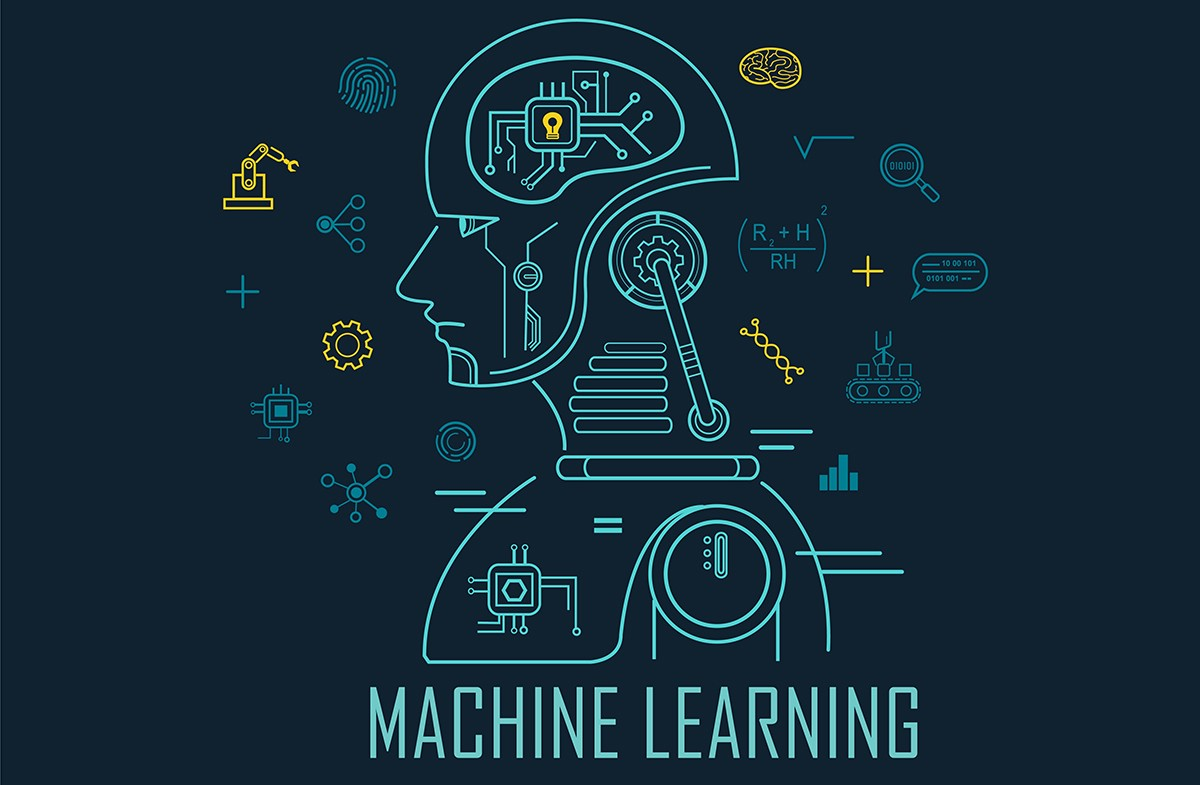

Now, we will start the model building. 
<li>We will start with a random model, to create a baseline and thus compare our sensible models with these results.
<li>Then we will move to Logistic Regression and Linear SVM. We are not using Kernel SVM for high time complexities. The Classifier such as Logistic Regression and Linear Regression really perform well when the data is high dimensional.
<li>We will then move to ensembles, starting with Bagging techniques such as RandomForest and ExtraTrees Classifiers. We will also use boosting Classifiers to further compare the performances. Since the bagging will be done for very deep Decision Trees, the train time complexity may be high for such a high dimensionality.
<li>Since we are using AUC as our KPI for tuning the models, and it is a case of imbalanced classification, we might have to do threshold tuning for some of the models, which do not give exact probabilities. We will use ROC Curve for threshold moving.
<li>Lastly, we will do stacking and blending and see if they help to improve the models further.
    <br><br>
    <b>Note:</b><br>
    We are handling the NaN values by replacing them with 0s only for Sklearn models. The boosting methods like XGBoost, LightGBM inherently handle NaN values as categories, and thus we don't need to explicitly impute any value to them.

## Random Model

This model randomly generates a probability value between 0 to 1, for each of the datapoint. This would serve as a baseline model, and that our any sensible model should not perform worse than this.

<b>Results Discussion</b>

<ol><li>The results for Linear SVM without dual formulation look very similar to the Logistic Regression Results. However, there is a very slight improvement in performance.</li>
    <li>Both the Train and CV AUC Scores for Linear SVM are slightly higher than that of Logistic Regression. The same can be seen from the Test AUC aswell, from the Kaggle.</li>
    <li>One interesting thing to note here is that the threshold probability comes out to be as low as 0.07.</li>
    <li>The Precision and Recall values are also almost the same, just slightly higher for Logisitc regression though.</li>
    <li>From the Confusion Matrix, we observe that the True Positives for Linear SVM are slightly lesser than that of Logistic Regression. </li>
    <li>The top 50 important features are also almost identical to the Logistic Regression. </li>
</ol>
Thus, we can conclude that the Logistic Regression and Linear SVM are behaving very similarly, as expected.

## Random Forest Classifier

In this section, we will use Bagging technique and train a Random Forest Classifier. We will be using Randomized Search technique to tune some of the hyperparameters of the RandomForestClassifier. 

<b>Results Discussion</b>
<ul><li>We see that the Random Forest Model performs worse than both Logistic Regression and Linear SVM.
    <li>We see a huge difference in the Training and Cross-Validation Scores. The model has a very high overfit. 
    <li>The Test AUC is also lower than both other models.
    <li>From the confusion matrix, we see that the number of False Positives is quite high, which affects our precision value. However, we see that there is a high value of Recall, which is actually good for business' perspective.
    <li>The Recall values of train and CV data also show that there is a high overfit to training data.
        </ul>
    
<br>
We see that the most important feature is again the TARGET Mean of 500 neighbors, similar to Logistic Regression, and Linear SVM. We also notice that most of the EXT_SOURCE features are among the highest scoring features. The features generated by using EXT_SOURCE raw features perform better than the raw features itself.


## ExtraTreesClassifier

This classifier is very much similar to the RandomForestClassifier, except that it only looks at only some random values for Information Gain while splitting the data for numeric features. 

<b>Results Discussion</b>

<ul><li>Except for a few differences, this model performs very similar to the RandomForest. </li>
    <li>The AUC and Recall values of this model are also inferior to the Random Forest. This can be seen from the Private Score as well.</li>
    <li>The Confusion Matrix shows significantly lesser True Positives for this model, as compared to all other models.</li>
    <li>The most important features also are same as those of RandomForest model.</li></ul>

## XGBoost GPU

For both XGBoost and LightGBM boosting, we have too many hyperparameters to tune, and doing GridSearchCV or RandomizedSearchCV can be too expesive on such a big dataset for finding an optimal solution. That is why we will be using the Bayesian Optimization Technique to tune the hyperparameters, which works by looking at the results on previous hyperparameters while assigning new hyperparameters. It tries to model on the Cost Function which is dependent on all the hyperparameters.

### Bayesian Optimization

In [28]:
def xgb_evaluation(max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel,
                   colsample_bynode, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of XGBoost's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel,
        colsample_bynode, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    params = {
        'learning_rate' : 0.01,
        'n_estimators' : 10000,
        'tree_method' : 'gpu_hist',
        'gpu_id' : 0,
        'max_depth' : int(round(max_depth)),
        'min_child_weight' : int(round(min_child_weight)),
        'subsample': subsample,
        'gamma' : gamma,
        'colsample_bytree' : colsample_bytree,
        'colsample_bylevel' : colsample_bylevel,
        'colsample_bynode' : colsample_bynode,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'random_state' : 51412
    }    
    
    #defining the Cross-Validation Strategry
    stratified_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 33)
    cv_preds = np.zeros(train_data.shape[0])
    
    #iterating over each fold, training the model, and making Out of Fold Predictions
    for train_indices, cv_indices in stratified_cv.split(train_data, target_train):
        
        x_tr = train_data.iloc[train_indices]
        y_tr = target_train.iloc[train_indices]
        x_cv = train_data.iloc[cv_indices]
        y_cv = target_train.iloc[cv_indices]
        
        xgbc = XGBClassifier(**params)
        xgbc.fit(x_tr, y_tr, eval_set= [(x_cv,y_cv)],
                        eval_metric='auc', verbose = False, early_stopping_rounds=200)
        
        cv_preds[cv_indices] = xgbc.predict_proba(x_cv, ntree_limit = xgbc.get_booster().best_ntree_limit)[:,1]
        gc.collect()   
        
    return roc_auc_score(target_train, cv_preds)

In [29]:
#defining the optimizer and the hyperparameters along with ranges of values.
bopt_xgb =  BayesianOptimization(xgb_evaluation, {'max_depth' : (5,15),
                                                  'min_child_weight' : (5,80),
                                                  'gamma' : (0.2,1),
                                                  'subsample' : (0.5,1),
                                                  'colsample_bytree' : (0.5,1),
                                                  'colsample_bylevel' : (0.3,1),
                                                  'colsample_bynode' : (0.3,1),
                                                  'reg_alpha' : (0.001, 0.3),
                                                  'reg_lambda' : (0.001, 0.3)}, 
                                 random_state = 55)

bopt_xgb.maximize(n_iter = 6, init_points = 4)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
[10:00:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:223: No visible GPU is found, setting `gpu_id` to -1


XGBoostError: [10:00:21] C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/gbm/gbtree.cc:588: Check failed: common::AllVisibleGPUs() >= 1 (0 vs. 1) : No visible GPU is found for XGBoost.

In [ ]:
#extracting the best parameters
target_values = []
for result in bopt_xgb.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']
    
print("Best Hyperparameters for XGBoost are:\n")
print(best_params)

### Training on Optimized Hyper-parameters

In [ ]:
#training on optimized hyperparameters
params = {
        'learning_rate' : 0.01,
        'n_estimators' : 10000,
        'tree_method' : 'gpu_hist',
        'gpu_id' : 0,
        'max_depth' : 5,
        'min_child_weight' : 80,
        'subsample': 0.9622896832878278,
        'gamma' : 0.794005454765522,
        'colsample_bytree' : 0.5741523601432443,
        'colsample_bylevel' : 0.3272128085080071,
        'colsample_bynode' : 0.9480907366417157,
        'reg_alpha' : 0.24018946957919934,
        'reg_lambda' : 0.23887141295582165,
        'random_state' : 51412,
    }    
xgb_boosting = Boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
xgb_boosting.train(booster = 'xgboost')

In [ ]:
#displaying the results and metrics
xgb_boosting.results()
#displaying top 50 important features
xgb_boosting.feat_importances_show(50)

In [ ]:
features_with_zero_importances = xgb_boosting.feature_importance[xgb_boosting.feature_importance.gain == 0]

print(f"There are {len(features_with_zero_importances)} features with Zero Gain in XGBClassifier. They are:\n")
print(features_with_zero_importances.features.values)

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : xgb_boosting.test_preds_proba_mean}).to_csv('XGBoost_3folds_final.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f XGBoost_3folds_final.csv -m "XGBoost 3 folds submission"
print('Successfully submitted to Home Credit Default Risk')

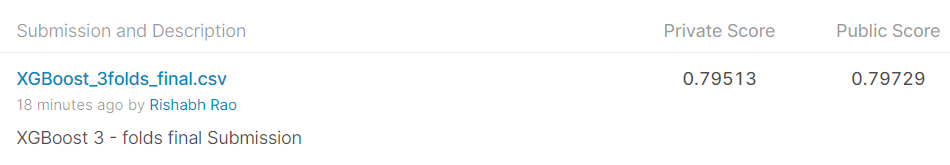

In [ ]:
with open('xgb_imp_feats.pkl','wb') as f:
    pickle.dump(xgb_boosting.feature_importance, f)
with open('xgb_cv_preds.pkl', 'wb') as f:
    pickle.dump(xgb_boosting.cv_preds_proba, f)
with open('xgb_test_preds.pkl', 'wb') as f:
    pickle.dump(xgb_boosting.test_preds_proba_mean, f)

<b>Results Discussion</b>

<ul><li>The XGBoost model with optimized Hyper-parameters seems to perform better than all the models used so far, by a margin. These results are reflected both for Cross-Validation, as well as Test Scores.</li>
    <li>The single model of XGBoost gives us a private Score of 0.79513 which is about top 7.6% in private leaderboard.</li>
    <li>The CV and Test AUC are also very close to each other, which implies similar distribution of training and test data.</li>
    <li>We notice here that the Recall Value for CV dataset is actually higher than Train Dataset, but the precision values are very low. </li>
    <li>Looking at the Confusion Matrix, we see that There are very few False Negatives, but the Numbers of False Positives is quite high. This is the trade-off between the recall and precision that we have to take.</li>
    <li>We have tuned the threshold by using the ROC-AUC curve, which tries to maximize the True Positive Rate (which we can see from the Confusion Matrix as well) and also to minimize the False Positive Rate, which is close to 0.047 here. </li>
    </ul>

<ul><b>Feature Importances</b>
    <li>The Tree Based methods give sensible feature importances. We see that the highest scoring feature according to Gini Gain is EXT_SOURCE_MEAN feature, which is the means of all the EXT_SOURCE values. We see lots of features generated from EXT_SOURCE as top scoring features. We also see the TARGET Mean of 500 neighbors as fifth highest scoring faeture. Among the other features, we notice that the features generated from Categorical interactions in application_train table have also scored high by the model.</li>
    <li>Among the 1236 features, we find that 48 features have exactly 0 Gini Gain, and we would be better off removing them if we were to use this classifier.</li></ul>

### Analysing the Feature Importances From XGBoost

Let us analyze the feature importances of the features obtained from XGBoost Model.

In [ ]:
#plotting the importance vs feature index for the features
plt.figure(figsize = (10,8))
plt.plot(list(range(len(xgb_feat_imp))), xgb_feat_imp.gain, color = 'r', linewidth = 2)
plt.xlabel('Feature Index')
plt.ylabel('Gini Gain')
plt.xticks(list(range(0,1300,100)))
plt.grid()
plt.title("Gini Gain vs Feature Index")
plt.show()

From the above figure we notice that there is an elbow point at about 100 features, after which the gain falls very rapidly. Let us try to exclude these first 100 highest scoring features, and try to observe more features.

In [ ]:
#plotting the importance vs feature index for the features
plt.figure(figsize = (10,8))
plt.plot(list(range(len(xgb_feat_imp)-100)), xgb_feat_imp.gain.iloc[100:], color = 'r', linewidth = 2)
plt.xlabel('Feature Index')
plt.ylabel('Gini Gain')
plt.xticks(ticks = list(range(0,1200,100)), labels = list(range(100,1300,100)))
plt.grid()
plt.title("Gini Gain vs Feature Index (excluding Top 100 features)")
plt.show()

Here again, we see a point of elbow of drop in feature importance/gini gain at feature index between 500-600 features. So we will take the top 600 features and try to model the XGBoostClassifier with same parameters on this reduced set of parameters, and compare the performance.

## XGBoost GPU on Reduced Feature Set

In [ ]:
#reducing the feature set
#taking the top 600 scoring features
train_data_600 = train_data[xgb_feat_imp.features.iloc[:600]]
test_data_600 = test_data[xgb_feat_imp.features.iloc[:600]]

print(f"Training Data Shape with reduced feature set = {train_data_600.shape}")
print(f"Test Data Shape with reduced feature set = {test_data_600.shape}")

### Training the model

In [ ]:
#training on the already optimized params above
xgb_boosting_600 = Boosting(train_data_600, target_train, test_data_600, params, random_state = 98, save_model_to_pickle = True)
xgb_boosting_600.train(booster = 'xgboost', pickle_name = '600feats')

In [ ]:
#displaying the results and metrics
xgb_boosting_600.results()
#displaying top 50 important features
xgb_boosting_600.feat_importances_show(50)

In [ ]:
with open('xgb_imp_feats_600feats.pkl','wb') as f:
    pickle.dump(xgb_boosting_600.feature_importance, f)
with open('xgb_cv_preds_600feats.pkl', 'wb') as f:
    pickle.dump(xgb_boosting_600.cv_preds_proba, f)
with open('xgb_test_preds_600feats.pkl', 'wb') as f:
    pickle.dump(xgb_boosting_600.test_preds_proba_mean, f)
with open('Final_XGBOOST_Selected_features', 'wb') as f:
    pickle.dump(xgb_boosting_600.feature_importance.features.values)

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : xgb_boosting_600.test_preds_proba_mean}).to_csv('XGBoost_600_features.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f XGBoost_600_features.csv -m ""
print('Successfully submitted to Home Credit Default Risk')

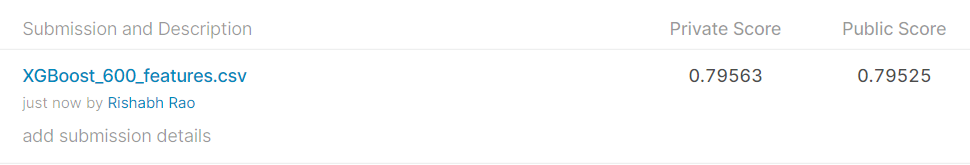

<b>Results Discussion</b>

<ol><li>From the results, we observe that the gap between CV and Train ROC-AUC Score has reduced, which means a little bit lesser over-fit compared to the model with all 1236 features.</li>
    <li>We also notice that the Recall has improved, while the Precision has reduced very slightly. </li>
    <li>The above point can also be realised by looking at the Confusion Matrix, which reported a higher number of True Positives now.</li>
    <li>The Private Score has also improved by removing the features. This implies that there might have been some noisy features, which were causing performance degradation.</li>
    <li>The Feature Importances remain more or less the same.</li></ol>
    
Thus, we can conclude that by removing the feature sets, we have both improved the performance, and reduced the computaional complexity of our model.

## LightGBM

### Bayesian Optimization

In [30]:
def lgbm_evaluation(num_leaves, max_depth, min_split_gain, min_child_weight,
                    min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Objective function for Bayesian Optimization of LightGBM's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    
    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 266
    }
    stratified_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 33)
    
    cv_preds = np.zeros(train_data.shape[0])
    for train_indices, cv_indices in stratified_cv.split(train_data, target_train):

        x_tr = train_data.iloc[train_indices]
        y_tr = target_train.iloc[train_indices]
        x_cv = train_data.iloc[cv_indices]
        y_cv = target_train.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                eval_metric='auc', verbose = False, early_stopping_rounds=200)

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration = lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(target_train, cv_preds)

In [ ]:
bopt_lgbm = BayesianOptimization(lgbm_evaluation, {'num_leaves' : (25,50),
                                                   'max_depth' : (6,11),
                                                   'min_split_gain' : (0, 0.1),
                                                   'min_child_weight' : (5,80),
                                                   'min_child_samples' : (5,80),
                                                   'subsample' : (0.5,1),
                                                   'colsample_bytree' : (0.5,1),
                                                   'reg_alpha' : (0.001, 0.3),
                                                   'reg_lambda' : (0.001, 0.3)},
                                 random_state = 4976)

bayesian_optimization = bopt_lgbm.maximize(n_iter = 6, init_points = 4)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.8057   |  0.9839   |  9.624    |  65.58    |  60.98    |  0.08223  |  39.55    |  0.1133   |  0.2049   |  0.6677   |
|  2        |  0.8064   |  0.5453   |  10.99    |  36.09    |  42.7     |  0.02383  |  43.12    |  0.1206   |  0.1951   |  0.8343   |


In [ ]:
#extracting the best parameters
target_values = []
for result in bopt_lgbm.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print("Best Hyperparameters obtained are:\n")
print(best_params)

### Training on Optimized Hyper-parameters

In [ ]:
params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : 39,
        'max_depth' : 9,
        'min_split_gain' : 0.030820727751758883,
        'min_child_weight' : 30.074868967458226,
        'min_child_samples' : 31,
        'subsample': 0.7653763123038788,
        'subsample_freq' : 1,
        'colsample_bytree' : 0.6175714684701181,
        'reg_alpha' : 0.15663020002553255,
        'reg_lambda' : 0.22503178038757748,
        'verbosity' : -1,
        'seed' : 266
    }
lgbm_boosting = Boosting(train_data, target_train, test_data, params, random_state = 98, save_model_to_pickle = True)
lgbm_boosting.train(booster = 'lightgbm')

In [ ]:
#displaying the results and metrics
lgbm_boosting.results()
#displaying top 50 important features
lgbm_boosting.feat_importances_show(50)

In [ ]:
features_with_zero_importances  = lgbm_boosting.feature_importance[lgbm_boosting.feature_importance.gain == 0]

print(f"There are {len(features_with_zero_importances)} features with Zero Gain in LGBMClassifier. They are:\n")
print(features_with_zero_importances.features.values)

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : lgbm_boosting.test_preds_proba_mean}).to_csv('LGBM_3folds.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f LGBM_3folds.csv -m "LightGBM - 3 Folds Submission"
print('Successfully submitted to Home Credit Default Risk')

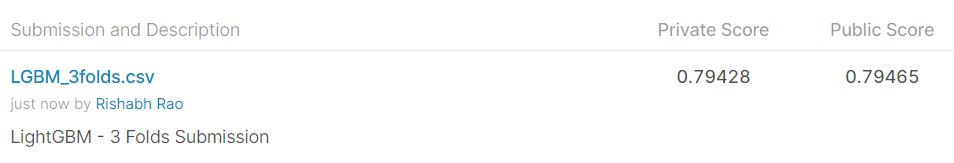

In [ ]:
with open('lgbm_imp_feats.pkl','wb') as f:
    pickle.dump(lgbm_boosting.feature_importance, f)
with open('lgbm_cv_preds.pkl', 'wb') as f:
    pickle.dump(lgbm_boosting.cv_preds_proba, f)
with open('lgbm_test_preds.pkl', 'wb') as f:
    pickle.dump(lgbm_boosting.test_preds_proba_mean, f)

<b>Results Discussion</b>

<ul><li>Firstly we see that the LightGBM model performs inferiorly as compared to XGBoost model, as observed from the results of Private Score on Test Data. This is contrary to the fact that LightGBM showed higher AUC value for CV dataset as compared to XGBoost.</li>
    <li>Again the Recall values are quite high, which is a good thing, but the precision values are again not good. The high recall value suggests that most of the actual defaulters are predicted by the model, but the low precision also indicates that model predicts lots of people as defaulters, while they actually aren't.</li>
    <li>We see from the Confusion Matrix that the number of True Positives are lesser in the Case of LightGBM compared to XGBoost. However, the total False Positives are also slightly lesser for LightGBM.</li>
    <li>We also observe that bost the boosting methods show the highest number of True Positives among all the models. This is aided by the high Recall value for these models as well.</li></ul>
    
<ul><b>Feature Importances</b>
    <li>We see that the feature TARGET Mean of 500 neighbors scores quite high as compared to all other features. The difference between gain is very significant. This implies that this feature is indeed a very important feature. </li>
    <li>Similar to all other ensembles, here too, the EXT_SOURCE features score high again.</li>
    <li>One of the interesting high scoring feature for LightGBM is the REGIONS_RATING_INCOME_MUL_1 which is the multiplication of Region Rating of Client with his Income. It has been treated as a categorical feature and has been response encoded, and gives better result than as a numeric feature.</li>
    <li>We also observe that there are around 41 features which had 0 gain in LGBMClassifier for splitting. This means they are not useful for our classifier.
    </ul>

## Stacking Classifiers

In this section, we will try to stack the best classifiers that we have used above, which include Logistic Regression, Linear SVM, Random Forest, XGBoost on reduced features and LightGBM. We will be training a LightGBM Classification Model on the Out-of-fold predictions for all the above classifiers. We will again use the BayesianOptimization Technique for tuning the hyperparameters. 

In [ ]:
def load_stacking_data(file_directory = '', verbose = True):
    '''
    Objective function to prepare the Stacking Training and Test Data. The training data is the
    Out-Of-Fold predictions of each base learners, and the test data are the predicted probabilities
    on the Test data.
    
    Inputs:
        file_directory: str, default = ''
            The path of directory where the predictions are located. Insert '/' in the end
        verbose: bool, default = True
            Whether to keep verbosity or not
    
    Returns:
        Training stacking data, Test stacking data, Trainig target values
    '''

    if verbose:
        print("Loading the CV (out-of-folds) and Test Predictions from Base Models...")
        start = datetime.now()
        
    global sgd_lr_l2_cv, sgd_svm_cv, rf_cv, xgb_cv, lgbm_cv
    global sgd_lr_l2_test, sgd_svm_test, rf_test, xgb_test, lgbm_test
    
    with open(file_directory + 'SGD_LR_L2_Penalty_CV_Preds.pkl', 'rb') as f:
        sgd_lr_l2_cv = pickle.load(f)
    with open(file_directory + 'SGD_Linear_SVM_CV_Preds.pkl', 'rb') as f:
        sgd_svm_cv = pickle.load(f)
    with open(file_directory + 'Random_Forest_CV_Preds.pkl', 'rb') as f:
        rf_cv = pickle.load(f)
    with open(file_directory + 'xgb_cv_preds_600feats.pkl', 'rb') as f:
        xgb_cv = pickle.load(f)
    with open(file_directory + 'lgbm_cv_preds.pkl', 'rb') as f:
        lgbm_cv = pickle.load(f)

    #loading the Predicted Probabilities of Test Set
    sgd_lr_l2_test = pd.read_csv(file_directory + 'SGD_L2_Penalty.csv')['TARGET']
    sgd_svm_test = pd.read_csv(file_directory + 'SGD_Linear_SVM.csv')['TARGET']
    rf_test = pd.read_csv(file_directory + 'Random_Forest.csv')['TARGET']
    xgb_test = pd.read_csv(file_directory + 'XGBoost_600_features.csv')['TARGET']
    lgbm_test = pd.read_csv(file_directory + 'LGBM_3folds.csv')['TARGET']
    
    if verbose:
        print("Making the Training and Test Dataset for Stacking...")
    #defining the training and test datasets
    stack_train = pd.DataFrame(np.stack([sgd_lr_l2_cv, sgd_svm_cv, rf_cv, xgb_cv, lgbm_cv], axis = 1), 
                              columns = ['SGD_LR_L2', 'SGD_SVM', 'RF', 'XGB', 'LGBM'])
    stack_target = target_train.copy()
    stack_test = pd.concat([sgd_lr_l2_test, sgd_svm_test, rf_test, xgb_test, lgbm_test], axis = 1)
    stack_test.columns = ['SGD_LR_L2', 'SGD_SVM', 'RF', 'XGB', 'LGBM']
    
    if verbose:
        print("Done.")
        print(f"Time elapsed = {datetime.now() - start}")
        print(f"Shape of stacking training data = {stack_train.shape}")
        print(f"Shape of stacking test data = {stack_test.shape}")
        print(f"Shape of stacking training class labels = {stack_target.shape}")
        
    return stack_train, stack_test, stack_target

In [ ]:
stack_train, stack_test, stack_target = load_stacking_data()

### Bayesian Optimization

In [ ]:
def lgbm_stacker_optimization(num_leaves, max_depth, min_split_gain, min_child_weight,
                             min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda):
    '''
    Function for Bayesian Optimization of LightGBM's Hyperparamters. Takes the hyperparameters as input, and
    returns the Cross-Validation AUC as output.
    
    Inputs: Hyperparamters to be tuned.
        num_leaves, max_depth, min_split_gain, min_child_weight,
        min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
        
    Returns:
        CV ROC-AUC Score
    '''
    
    params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : int(round(num_leaves)),
        'max_depth' : int(round(max_depth)),
        'min_split_gain' : min_split_gain,
        'min_child_weight' : min_child_weight,
        'min_child_samples' : int(round(min_child_samples)),
        'subsample': subsample,
        'subsample_freq' : 1,
        'colsample_bytree' : colsample_bytree,
        'reg_alpha' : reg_alpha,
        'reg_lambda' : reg_lambda,
        'verbosity' : -1,
        'seed' : 8956
    }
    stratified_cv = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 96)
    
    cv_preds = np.zeros(stack_train.shape[0])
    for train_indices, cv_indices in stratified_cv.split(stack_train, stack_target):

        x_tr = stack_train.iloc[train_indices]
        y_tr = stack_target.iloc[train_indices]
        x_cv = stack_train.iloc[cv_indices]
        y_cv = stack_target.iloc[cv_indices]

        lgbm_clf = lgb.LGBMClassifier(**params)
        lgbm_clf.fit(x_tr, y_tr, eval_set= [(x_cv, y_cv)],
                eval_metric='auc', verbose = False, early_stopping_rounds=200)

        cv_preds[cv_indices] = lgbm_clf.predict_proba(x_cv, num_iteration = lgbm_clf.best_iteration_)[:,1]

    return roc_auc_score(stack_target, cv_preds)

In [ ]:
bopt_stacking = BayesianOptimization(lgbm_stacker_optimization, {'num_leaves' : (2,50),
                                                   'max_depth' : (2,6),
                                                   'min_split_gain' : (0, 0.5),
                                                   'min_child_weight' : (1,80),
                                                   'min_child_samples' : (5,80),
                                                   'subsample' : (0.001,1),
                                                   'colsample_bytree' : (0.2,1),
                                                   'reg_alpha' : (0.00001, 0.3),
                                                   'reg_lambda' : (0.00001, 0.3)},
                                 random_state = 6569)

bayesian_optimization = bopt_stacking.maximize(n_iter = 10, init_points = 10)

In [ ]:
#extracting the best parameters
target_values = []
for result in bopt_stacking.res:
    target_values.append(result['target'])
    if result['target'] == max(target_values):
        best_params = result['params']

print("Best Hyperparameters obtained are:\n")
print(best_params)

### Training on Optimized Hyper-parameters

In [ ]:
params = {
        'objective' : 'binary',
        'boosting_type' : 'gbdt',
        'learning_rate' : 0.005,
        'n_estimators' : 10000,
        'n_jobs' : -1,
        'num_leaves' : 3,
        'max_depth' : 5,
        'min_split_gain' : 0.10600273039230335,
        'min_child_weight' : 25.462380118091218,
        'min_child_samples' : 32,
        'subsample': 0.5194861616343917,
        'subsample_freq' : 1,
        'colsample_bytree' : 0.653278704808709,
        'reg_alpha' : 0.17957695696091033,
        'reg_lambda' : 0.13028216024797987,
        'verbosity' : -1,
        'seed' : 266
    }
stacker_boosting = Boosting(stack_train, stack_target, stack_test, params, random_state = 96, num_folds = 4)
stacker_boosting.train(booster = 'lightgbm')

In [ ]:
#displaying the results and metrics
stacker_boosting.results(confusion_matrix = False, cv_test_distribution = False)
#displaying top 50 important features
stacker_boosting.feat_importances_show(5, figsize = (8,5))

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : stacker_boosting.test_preds_proba_mean}).to_csv('LGBM_Stacker_4_Fold.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f LGBM_Stacker_4_Fold.csv -m "LightGBM Stacker with Data from 5 base classifiers"
print('Successfully submitted to Home Credit Default Risk')

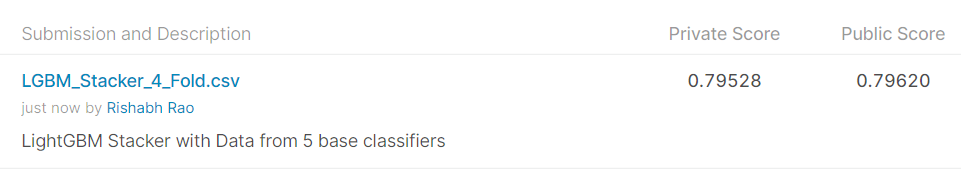

<b>Results Discussion</b>

<ul><li>From the stacking classifier, we see that the both the CV and Private Score obtained are the higher than all the base classifiers. </li>
    <li>We also observe that the recall value is very high, but the Precision value has gone down even further.</li>
    <li>This stacking model, however, performs worse than a single XGB model, this could be due to the low number of base models. Also the base classifiers might be correlated with each other too, so that may also have caused low performance with stacking.</li>
    <li>From the Feature Importance of LightGBM, we see that the LGBM base model's predictions score the highest among all the base classifiers, which is followed by XGB's predictions. The least importance comes out for the Random Forest Classifier's predictions.</li></ul>
   

## Blending of Predictions

Based on the feature importances obtained from the Stacking Classifier, we will now try to blend the predictions of all classifiers, in a ratio proportion to their feature importances from above.

In [ ]:
#getting the feature importance from stacking classifier
feat_imp_gain_stacking = stacker_boosting.feature_importance
#normalizing the gain values to lie between 0 to 1
feat_imp_gain_stacking.gain = feat_imp_gain_stacking.gain / sum(feat_imp_gain_stacking.gain)
print("Normalized Gain Value as per Stacking Classifier for each base models are:")
display(feat_imp_gain_stacking)

In [ ]:
blended_cv_preds = sgd_lr_l2_cv * 0.020748 + sgd_svm_cv * 0.064836 + rf_cv * 0.003137 + xgb_cv * 0.287625 + lgbm_cv * 0.623653
blended_test_preds = sgd_lr_l2_test * 0.020748 + sgd_svm_test * 0.064836 + rf_test * 0.003137 + xgb_test * 0.287625 + lgbm_test * 0.623653

#tuning the threshold again
fpr, tpr, threshold = roc_curve(target_train, blended_cv_preds)
j = tpr - fpr
best_threshold = threshold[np.argmax(j)]
#calculating the metrics values
print("Results on CV Dataset:")
print("="*100)
print(f"\nThe best selected Threshold as per the J-Statistic, which is J = TPR - FPR, is = {best_threshold}\n")
print(f"ROC-AUC Score CV = {roc_auc_score(target_train, blended_cv_preds)}")
print(f"Precison Score CV = {precision_score(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))}")
print(f"Recall Score CV = {recall_score(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))}") 

print('=' * 100)
print("Confusion Matrix of CV data:")
conf_mat = confusion_matrix(target_train, np.where(blended_cv_preds >= best_threshold, 1, 0))
conf_mat = pd.DataFrame(conf_mat, columns = ['Predicted_0','Predicted_1'], index = ['Actual_0','Actual_1'])
plt.figure(figsize = (7,6))
plt.title('Confusion Matrix Heatmap')
sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
plt.show()
print("="*100)

In [ ]:
#submitting the result
pd.DataFrame({'SK_ID_CURR': skid_test, 'TARGET' : blended_test_preds}).to_csv('Blending_all.csv',index = False)
!kaggle competitions submit -c home-credit-default-risk -f Blending_all.csv -m "Blending of results of 5 base classifiers"
print('Successfully submitted to Home Credit Default Risk')

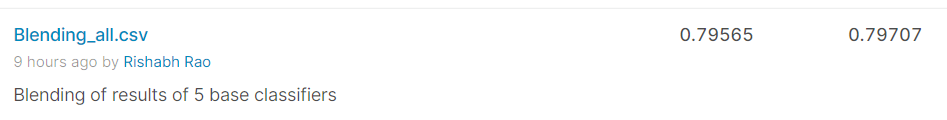

<b>Results Discussion</b>

<ul>
<li>We see that this blended model shows the second highest CV ROC-AUC among all models.</li>
<li>It was a rather more heuristic process, as we just used the importance of each model obtained from Stacking Classifier as its weight to blend, and it turns out to give the best ROC-AUC among all the models so far, on Test Dataset.</li>
<li>However, the Recall and Precision values are not that good. This might require rather more rigorous threshold tuning to improve the results a bit more.</li>
    </ul>

# Results Summarization

In [ ]:
results_df = pd.DataFrame([['Random Model', np.round(0.5001812688821752, 5), '-', np.round(0.5001144672273913, 5), '-', 0.49396, 0.50128, '99.37%'],
                            ['Dominant Class', 0.0, '-', np.round(0.5010095061750377, 5), '-', 0.49530, 0.49055, '99.33%'],
                            ['SGD LogisticRegression L2', np.round(0.7472306143001007,5), np.round(0.7363947633434038,5), 
                               np.round(0.7971552091816715,5), np.round(0.7907336258401249,5), 0.77848, 0.78283, '56.51%'],
                            ['SGD Linear SVM', np.round(0.7457804632426989, 5), np.round(0.7369587109768378, 5), 
                                      np.round(0.7980921976293923, 5), np.round(0.7915505286711596, 5), 0.77955, 0.78299, '55.08%'],
                            ['RandomForestClassifier', np.round(0.8091440080563947, 5), np.round(0.7290231621349446, 5),
                                      np.round(0.8321734127843617, 5), np.round(0.7775905555143139, 5), 0.76457, 0.77192, '65.24%'],
                            ['ExtraTreesClassifier', np.round(0.9113393756294058, 5), np.round(0.60269889224572, 5),
                                      np.round(0.932770629575878, 5), np.round(0.7720865925495278, 5), 0.76164, 0.77116, '66.44%'],
                            ['XGBoostClassifier', np.round(0.7999194360523666, 5), np.round(0.8642497482376637, 5), 
                                      np.round(0.8743687606924759, 5), np.round(0.8051278105368123, 5), 0.79513, 0.79729, '6.30%'],
                            ['XGBoostClassifier - 600 Features', np.round(0.8010070493454179, 5), np.round(0.8686807653575025, 5), 
                                      np.round(0.8702218691280733, 5), np.round(0.8046982367776565, 5), 0.79563, 0.79525, '7.26%'],
                            ['LightGBMClassifier', np.round(0.8262638469284995, 5), np.round(0.8406042296072508, 5), 
                                      np.round(0.9045251207764887, 5), np.round(0.8061038615922426, 5), 0.79428, 0.79465, '10.65%'],
                            ['StackingClassifier', np.round(0.736797583081571, 5), np.round(0.9398590130916414, 5),
                                      np.round(0.807872515009856, 5), np.round(0.8066312491185976, 5), 0.79528, 0.79620, '7.23%'],
                            ['Blending Results', '-', np.round(0.7424370594159114, 5), '-', np.round(0.8066127071870559, 5),
                                      0.79565, 0.79707, '6.24%']], 
                          columns = ['Model', 'Train Recall', 'CV Recall', 'Train ROC-AUC', 'CV ROC-AUC', 
                                     'Private Score (ROC-AUC)', 'Public Score (ROC-AUC)', 'Percentile Private LB'], index = list(range(1,12)))

display(results_df)

From the above results, we observe that the:
<ul><li>The highest Cross-Validation Recall value was obtained for Stacking Classifier Model, which is then followed by XGBoostClassifier Model.</li>
    <li>The Highest CV ROC-AUC was observed for StackingClassifier, followed by Blended Model, then LightGBM and XGBoost. They all are pretty close to each other.</li>
    <li>The best Private Score (ROC-AUC) was observed again for the blending model, which took into consideration the Predictions from all the base learners.</li>
    <li>Throughout the table, we can see that the CV and Test ROC-AUC are pretty close to each other, wich a consistent gap of around 0.1 between them. Thus CV can be used as a sensible measure for keeping track of Private LB score.</li>
    <li>Overall the Boosting Models out-performed the other models by a margin, as can be seen from both the CV and Private Score. However, the linear models like Logistic Regression and Linear SVM performed better thatn RandomForest Ensemble. This could be due to the high dimensionality of the dataset</li></ul>

# Final DataFrame with Reduced Features for Pipeline

Based on the features eliminated above, we will remove them from the relational tables, which will be loaded into memory during Productionization time, to be merged with main application_test datapoints.

In [ ]:
relational_tables_prepare()